# Bonus Challenge 2

## TOPIC 1: Churn prediction and prevention in e-commerce

Contributors:

**Meritxell Camp Garcia (Student ID: A0280366B)**<br>
**Sidharth Pahuja (Student ID: A0218880X)**<br>

### Content:

1. Objective & Conclusion

2. EDA and data processing

3. Models
- 3.1. Logistic Classifiers
    - 3.1.1. Degree 1
    - 3.1.2. Degree 2
- 3.2. SVC Classifiers
    - 3.2.1. Degree 1
    - 3.2.2. Degree 2
- 3.3. Tree Classifiers
    - 3.3.1. Degree 1
    - 3.3.2. Degree 2
    - 3.3.3. Gradient Boosting
    - 3.3.4. Random Forest

\4. Expected Value & Churn Prevention
    

# 1. Objective & Conclusion

The objective of this project is to predict customer churn for a large e-commerce company and in doing so, also identify the top factors impacting customer churn. Additionally, we aim to assist the e-commerce company in running more profitable retention marketing campaigns. Our classification metric of interest will be recall, and the reason for this will be explained in the later sections.  

We will use the following 3 models for our analysis:

- Logistic Regression: We will use logistic regression classifiers with degrees 1 and 2. For degree 2, we will limit our focus on the interaction terms only (this will be explained later in the below sections). Furthermore, we will also use grid search to decide the best parameters for regularization.

- Linear SVC: We will use linear svc classifiers with degrees 1 and 2. For degree 2, we will limit our focus on the interaction terms only. Furthermore, we will also use grid search to decide the best parameters for margins.

- Decision Tree: We will use decision trees with with degrees 1 and 2. For degree 2, we will limit our focus on the interaction terms only. Furthermore, we will also use grid search to decide the best parameters for maximum depth and maximum leaf nodes.

Due to decision tree model with degree 2 performing worse than degree 1, we will stick to the tree model with degree 1. Inherently, decision trees already include feature interaction in their nature, and excluding additional polynomial features should not lead to a high loss of information. However, to improve the robustness of our results from degree 1 tree and reduce bias, we will apply boosting. Furthermore, we will also apply random forest to our dataset with maximum features parameter set to none. This will essentially allow us to use random forest to average many trees (which are allowed to use all the variables for decision boundaries) and get more robust results. 

Finally, we will derive a cost-benefit matrix for our customers and evaluate all the models. Based on the expected values obtained, we observed that the random forest model performs the best amongst all, and will hence become our choice of model for this project.

Note: We are using the e-commerce churn dataset that has been obtained from Kaggle.
Link: https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction

In [321]:

#importing all the relevant libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier


import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

# 2. EDA AND DATA PROCESSING

## Data Pre-processing


In our dataset, we have identified missing values across several columns: 'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', and 'DaySinceLastOrder'. We have formulated tailored strategies to address these nulls effectively:

- **Tenure:** Null values are replaced with zero, reflecting the logical assumption that customers with no recorded tenure have not yet commenced their relationship with the platform, thus having zero months of tenure.

- **WarehouseToHome:** We employ an Iterative Imputer to predict the missing distances from the warehouse to customers' homes, leveraging other related attributes to inform our estimations.

- **HourSpendOnApp:** Absence of data on the time spent in the app is treated as zero usage, under the presumption that unrecorded usage equates to no usage.

- **OrderAmountHikeFromlastYear:** This metric represents the year-over-year increase in a customer's purchase amount. If a customer did not make purchases in the previous year, resulting in a null value, we interpret this as a zero percent increase and thus impute nulls with zero.

- **CouponUsed:** We infer that null values in this column indicate the non-utilization of coupons. Therefore, we replace nulls with zero.

- **OrderCount:** A null value here suggests that no orders have been recorded for the customer. To maintain data integrity, we fill these nulls with zero, indicating no orders have been placed.

- **DaySinceLastOrder:** Given that we do not have a reliable method for estimating the time since the last order when data is missing, we opt to remove rows with null values in this column to preserve the accuracy of our analyses.We ultimately remove 307 rows (5% of rows).

In [2]:
df = pd.read_csv('ecommerce_data.csv', sep= ";",index_col = 0)
df

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
CustomerID                                                                  
50001           1     4.0         Mobile Phone         3              6.0   
50002           1     NaN                Phone         1              8.0   
50003           1     NaN                Phone         1             30.0   
50004           1     0.0                Phone         3             15.0   
50005           1     0.0                Phone         1             12.0   
...           ...     ...                  ...       ...              ...   
55626           0    10.0             Computer         1             30.0   
55627           0    13.0         Mobile Phone         1             13.0   
55628           0     1.0         Mobile Phone         1             11.0   
55629           0    23.0             Computer         3              9.0   
55630           0     8.0         Mobile Phone         1             15.0   

           PreferredPaymentMode  Gender  HourSpendOnApp  \
CustomerID                                                
50001                Debit Card  Female             3.0   
50002                       UPI    Male             3.0   
50003                Debit Card    Male             2.0   
50004                Debit Card    Male             2.0   
50005                        CC    Male             NaN   
...                         ...     ...             ...   
55626               Credit Card    Male             3.0   
55627               Credit Card    Male             3.0   
55628                Debit Card    Male             3.0   
55629               Credit Card    Male             4.0   
55630               Credit Card    Male             3.0   

            NumberOfDeviceRegistered    PreferedOrderCat  SatisfactionScore  \
CustomerID                                                                    
50001                              3  Laptop & Accessory                  2   
50002                              4              Mobile                  3   
50003                              4              Mobile                  3   
50004                              4  Laptop & Accessory                  5   
50005                              3              Mobile                  5   
...                              ...                 ...                ...   
55626                              2  Laptop & Accessory                  1   
55627                              5             Fashion                  5   
55628                              2  Laptop & Accessory                  4   
55629                              5  Laptop & Accessory                  4   
55630                              2  Laptop & Accessory                  3   

           MaritalStatus  NumberOfAddress  Complain  \
CustomerID                                            
50001             Single                9         1   
50002             Single                7         1   
50003             Single                6         1   
50004             Single                8         0   
50005             Single                3         0   
...                  ...              ...       ...   
55626            Married                6         0   
55627            Married                6         0   
55628            Married                3         1   
55629            Married                4         0   
55630            Married                4         0   

            OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
CustomerID                                                        
50001                              11.0         1.0         1.0   
50002                              15.0         0.0         1.0   
50003                              14.0         0.0         1.0   
50004                              23.0         0.0         1.0   
50005                              11.0         1.0         1.0   
...                          

In [3]:
null_counts = df.isnull().sum()
print(null_counts)

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64


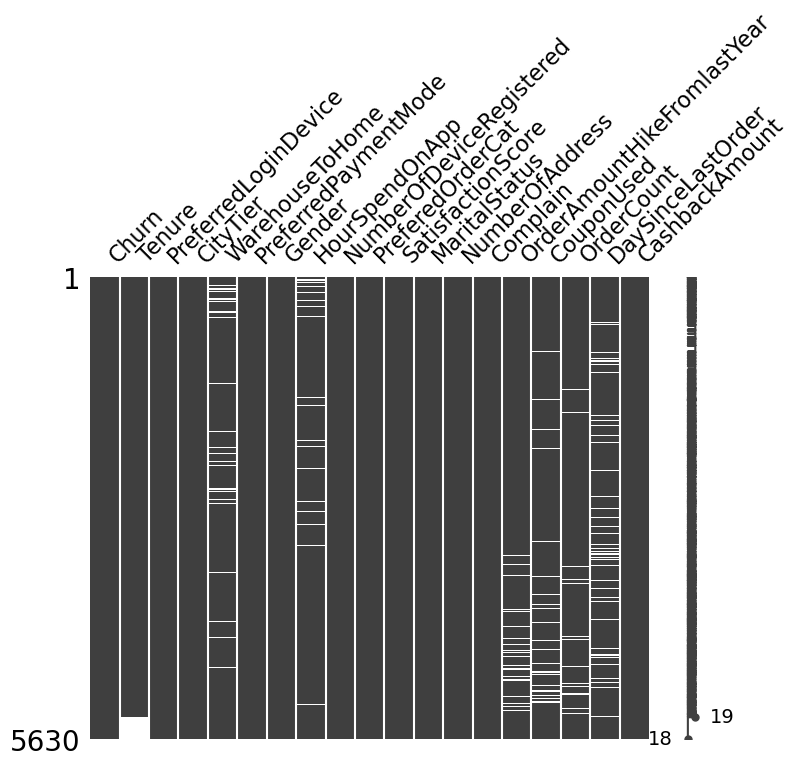

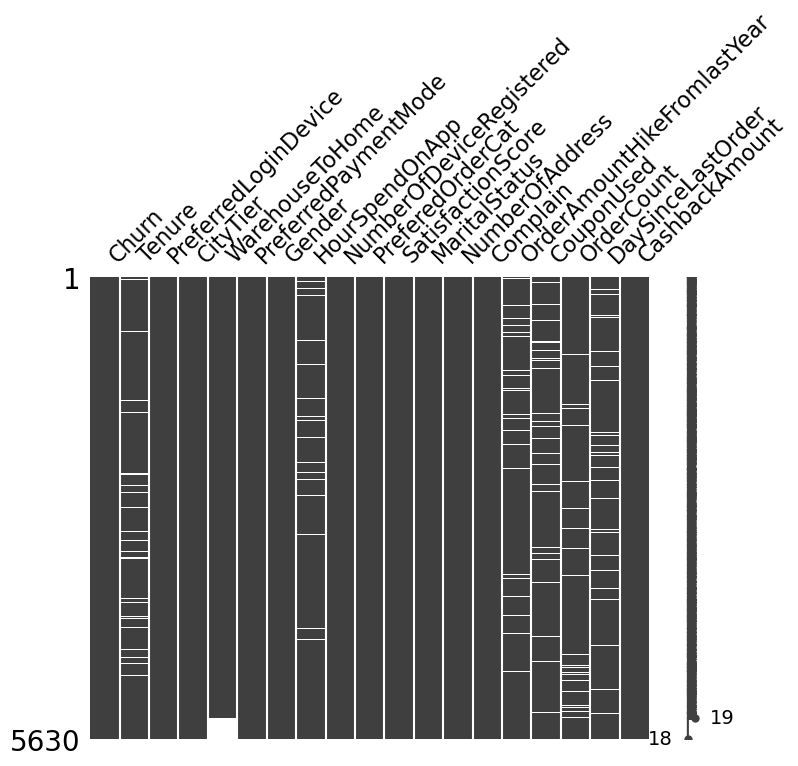

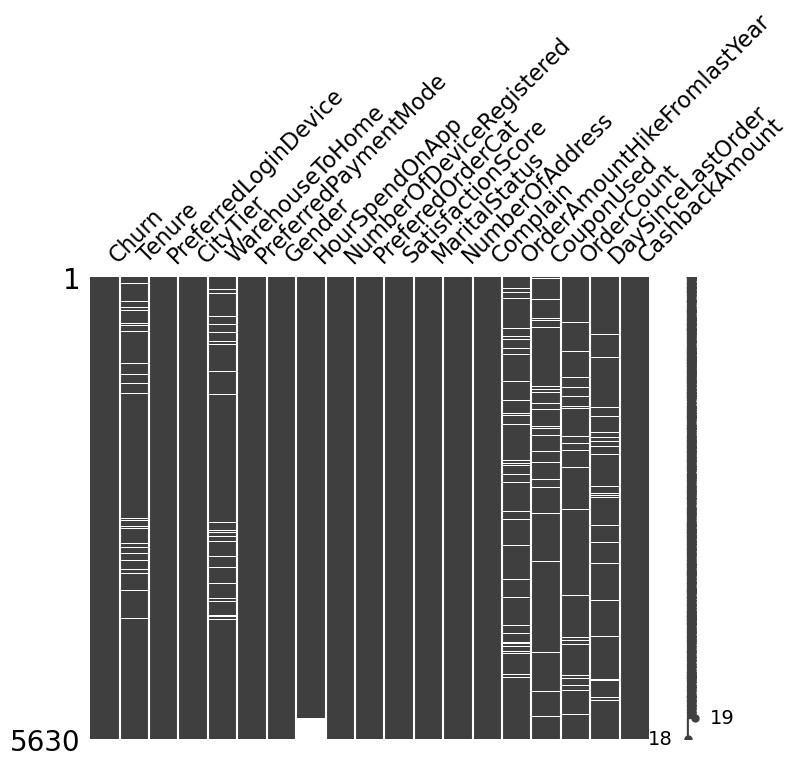

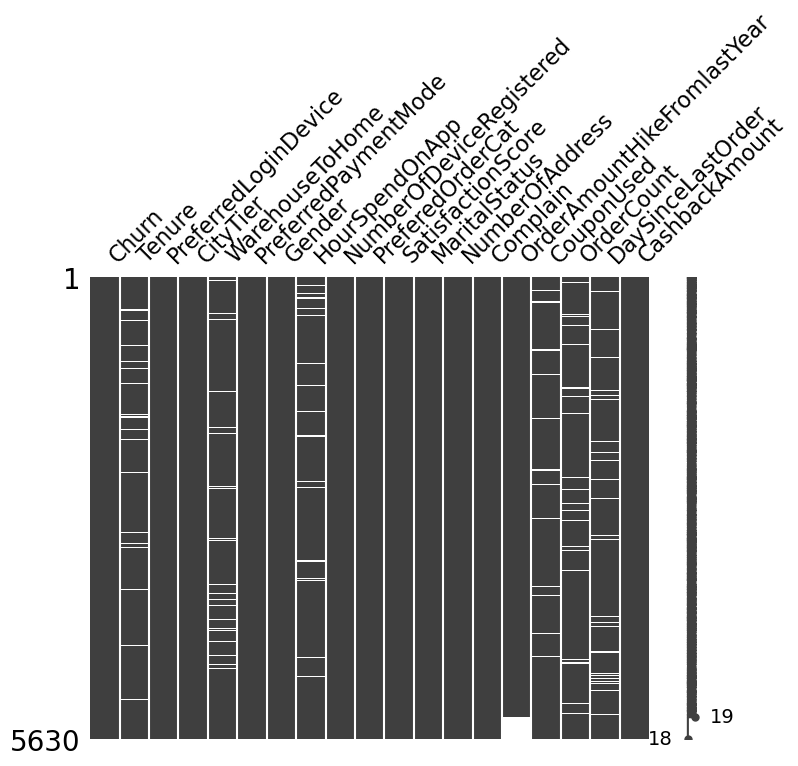

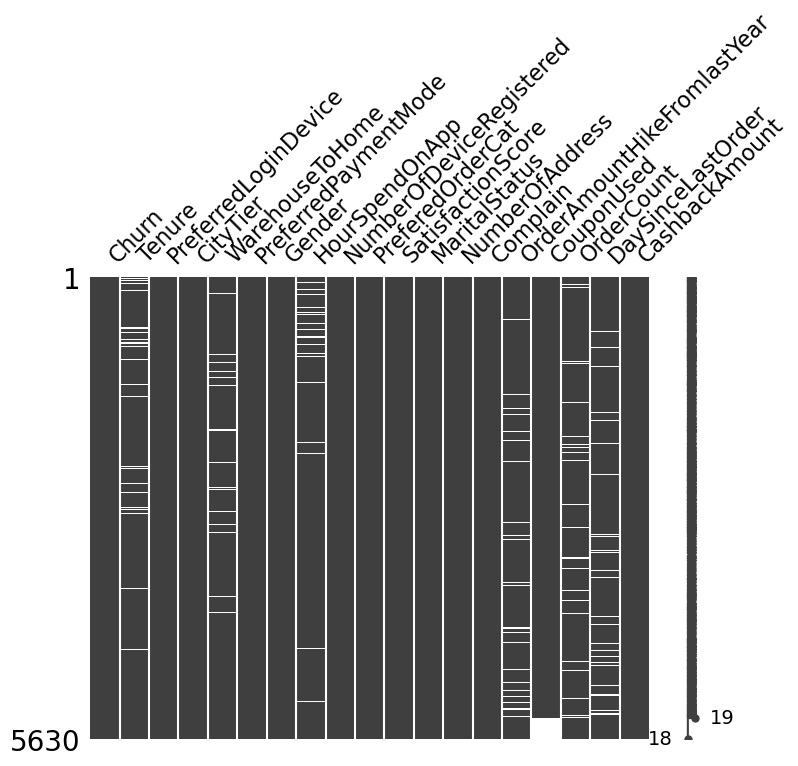

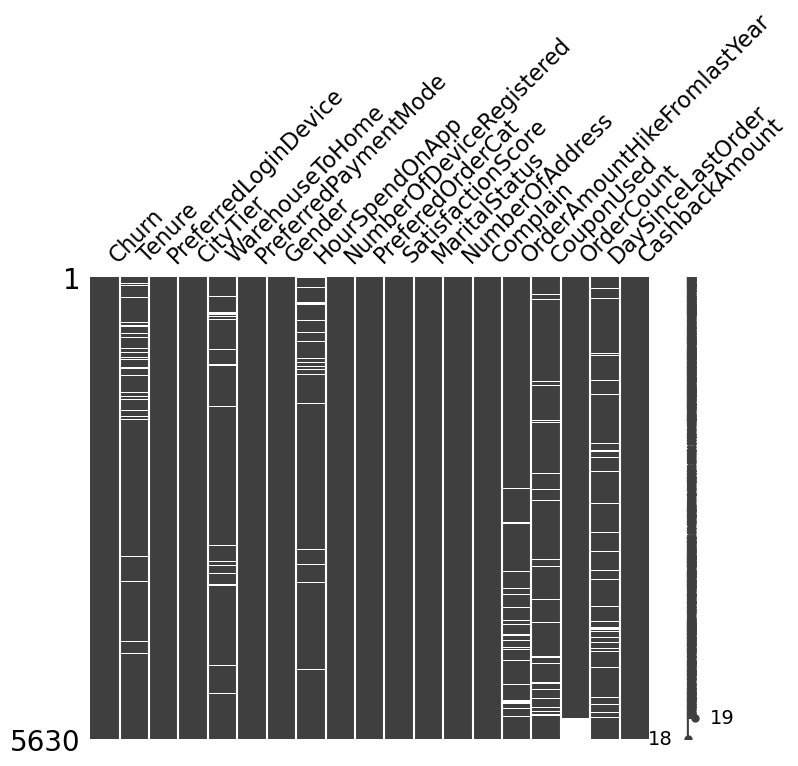

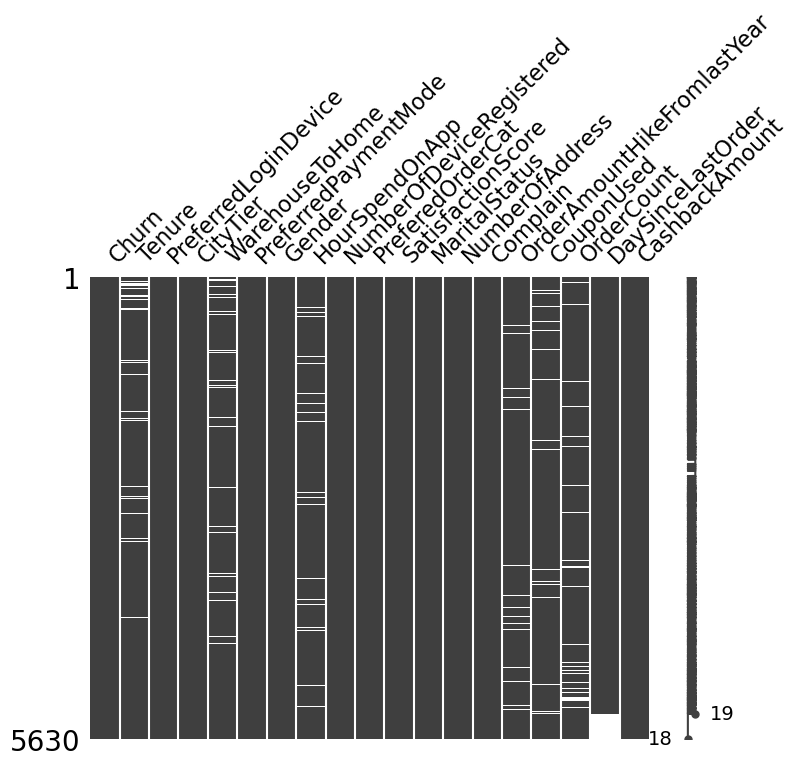

In [4]:
import missingno as msno

problematic = ['Tenure','WarehouseToHome','HourSpendOnApp','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder']

for problem in problematic:
    msno.matrix(df.sort_values(by=problem),figsize=(8,6))
    plt.show()

In [5]:
df.describe()

Churn       Tenure     CityTier  WarehouseToHome  HourSpendOnApp  \
count  5630.000000  5366.000000  5630.000000      5379.000000     5375.000000   
mean      0.168384    10.189899     1.654707        15.639896        2.931535   
std       0.374240     8.557241     0.915389         8.531475        0.721926   
min       0.000000     0.000000     1.000000         5.000000        0.000000   
25%       0.000000     2.000000     1.000000         9.000000        2.000000   
50%       0.000000     9.000000     1.000000        14.000000        3.000000   
75%       0.000000    16.000000     3.000000        20.000000        3.000000   
max       1.000000    61.000000     3.000000       127.000000        5.000000   

       NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  \
count               5630.000000        5630.000000      5630.000000   
mean                   3.688988           3.066785         4.214032   
std                    1.023999           1.380194         2.583586   
min                    1.000000           1.000000         1.000000   
25%                    3.000000           2.000000         2.000000   
50%                    4.000000           3.000000         3.000000   
75%                    4.000000           4.000000         6.000000   
max                    6.000000           5.000000        22.000000   

          Complain  OrderAmountHikeFromlastYear   CouponUsed   OrderCount  \
count  5630.000000                  5365.000000  5374.000000  5372.000000   
mean      0.284902                    15.707922     1.751023     3.008004   
std       0.451408                     3.675485     1.894621     2.939680   
min       0.000000                    11.000000     0.000000     1.000000   
25%       0.000000                    13.000000     1.000000     1.000000   
50%       0.000000                    15.000000     1.000000     2.000000   
75%       1.000000                    18.000000     2.000000     3.000000   
max       1.000000                    26.000000    16.000000    16.000000   

       DaySinceLastOrder  CashbackAmount  
count        5323.000000     5630.000000  
mean            4.543491      177.221492  
std             3.654433       49.193869  
min             0.000000        0.000000  
25%             2.000000      146.000000  
50%             3.000000      163.000000  
75%             7.000000      196.000000  
max            46.000000      325.000000

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# imputing the nulls
# churn: drop na rows
# DaySinceLastOrder: drop na rows
df.dropna(subset=['Churn', 'DaySinceLastOrder'], inplace=True)

# tenure: nulls --> 0
# OrderAmountHikeFromlastYear: nulls --> 0
# CouponUsed: nulls --> 0
# OrderCount: nulls --> 0
# HourSpendOnApp: nulls --> 0
columns_to_fill = ['Tenure', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'HourSpendOnApp']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# WarehouseToHome: nulls --> InterativeInputer
imputer = IterativeImputer(random_state=2023)
column_to_impute = 'WarehouseToHome'
column_array = df[[column_to_impute]].values
column_array_imputed = imputer.fit_transform(column_array)
df[column_to_impute] = column_array_imputed

In [6]:
null_counts = df.isnull().sum()
print(null_counts)

Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64


In [7]:
#PreferredPaymentMode -> map cc and credit card together, map COD and cash on delivery together
payment_method_mapping = {'CC': 'Credit Card', 'COD': 'Cash on Delivery'}
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace(payment_method_mapping)

#PreferredLoginDevice -> map phone and mobile phone together
preferred_login_device_mapping = {'Phone': 'Mobile Phone'}
df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace(preferred_login_device_mapping)

#PreferedOrderCat -> map phone and mobile phone together
preferred_order_category_mapping = {'Mobile': 'Mobile Phone'}
df['PreferedOrderCat'] = df['PreferedOrderCat'].replace(preferred_order_category_mapping)

## Exploratory Data Analysis (EDA)

In this step, we want to generate descriptive analytics insights from our database and generate our first hypothesis on factors contributing to churn. 

### Correlation
<div class="alert alert-block alert-success">


We observe a positive correlation between churn and factors such as ‘Complain’, ‘Satisfaction Score’, and ‘Number of Devices Registered’. This correlation aligns with expectations: customers who have had negative experiences in the past are likely less inclined to continue purchasing from the same platform. The 'Satisfaction Score' scale ranges from 1 (Most Satisfied) to 5 (Least Satisfied). Intuitively, this suggests that lower satisfaction levels correlate with a higher likelihood of customer churn. Additionally, customers registering multiple devices on the platform could indicate potential fraudulent activity or lifestyle changes that affect their purchasing patterns.

Conversely, there's a negative correlation with ‘Tenure’, ‘Cashback Amount’, and ‘Days Since Last Order’. This trend is logical: longer-standing customers typically exhibit more loyalty and are less prone to churn. Moreover, cashback incentives appear to be a significant factor in retaining users. The ‘Days Since Last Order’ metric offers insights into purchase frequency. We can reasonably infer that customers with more frequent transactions are less likely to churn, underscoring the importance of regular engagement in customer retention strategies.


In [8]:

corr_variables = ['Churn','Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 
             'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 
             'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 
             'DaySinceLastOrder', 'CashbackAmount']

df[corr_variables].corr().style.background_gradient(cmap='bwr_r', vmin=-1, vmax=1)


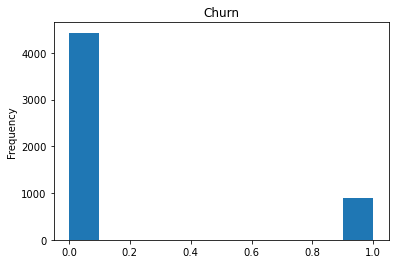

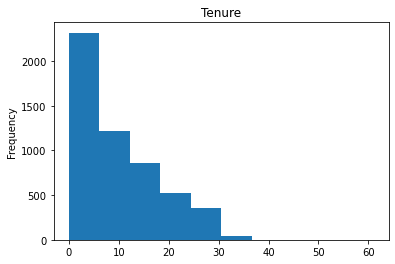

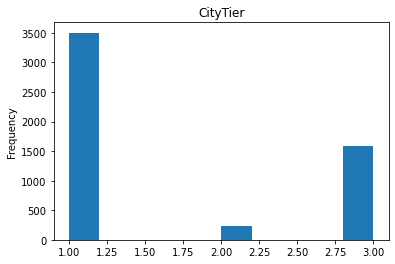

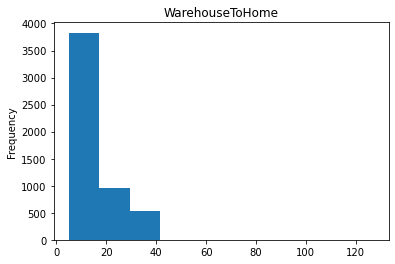

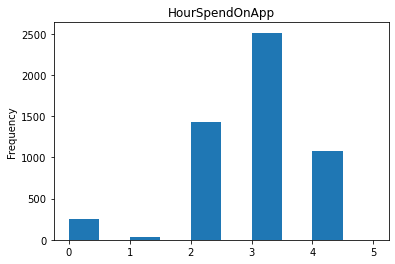

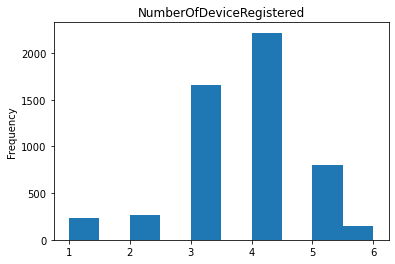

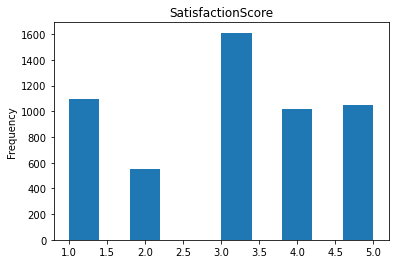

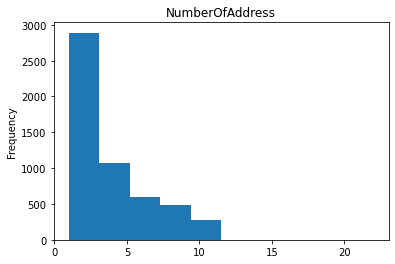

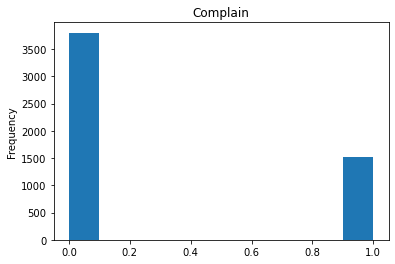

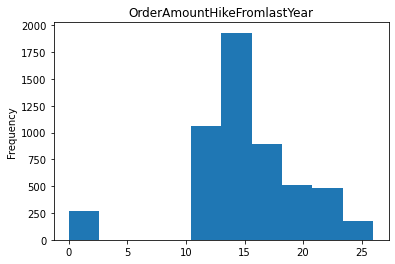

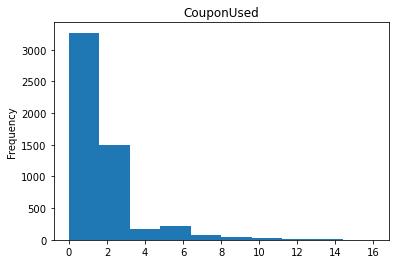

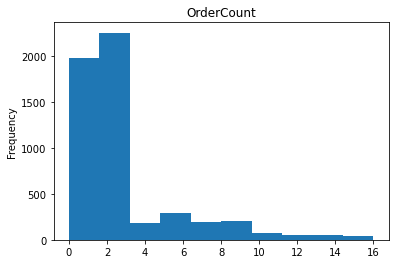

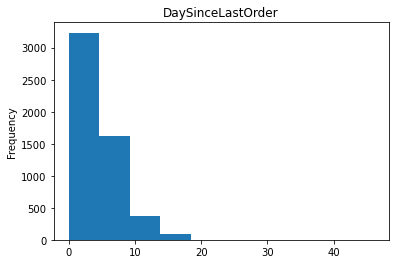

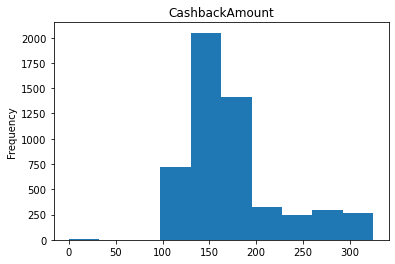

In [9]:
variables = ['Churn', 'Tenure', 'CityTier',
       'WarehouseToHome',  'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'SatisfactionScore',
        'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount']

for value in variables:
    data = df[value]
    ax = data.plot.hist(title=value)
    plt.show()
    

## Interaction between Churn and numerical features
<div class="alert alert-block alert-success">


Overall, the data suggests that churn is driven by a combination of factors related to customer engagement, satisfaction, and perceived value. Newer customers or those who have had a negative service experience, especially those who have complained, are more likely to churn. Retention efforts could focus on improving the initial customer experience, avoid complaints proactively, engaging customers through the app, and providing value through incentives like cashbacks and coupons. It's also important to note that frequent interaction, whether through app usage or regular purchasing, seems to be a key component in reducing churn.


**- Tenure:** Customers with lower tenure have a significantly higher percentage of churn. This suggests that newer customers are more likely to churn, which could indicate issues with early customer experience or engagement.

**- CityTier:** There appears to be a higher churn rate for customers in certain city tiers. The difference in churn by city tier could reflect varying levels of service or customer satisfaction based on the maturity of the city. Tier 1 cities show a lower percentage of churn, and Tier 3 cities show a higher percentage of churn. Tier 1 are probably mature cities with an established customer based, while Tier 3 cities are less mature cities. 

**- WarehouseToHome:** The churn seems to be slightly higher among customers with a higher distance from the warehouse to home. This data might be an indication of time to deliver, with longer distances indicating longer ETAs for customers, with customers having to wait longer being more prone to be unsatisfied and consequently, churn.

**- HourSpendOnApp:** Most churn occurs among customers who spend fewer hours on the app, highlighting the importance of app engagement in customer retention.

**- NumberOfDeviceRegistered:** A higher number of devices registered does not clearly correlate with churn. However, there is a churn increase among those with 5 or 6 devices registered.

**- SatisfactionScore:** Higher churn rates are evident among customers with poor satisfaction scores, underscoring the critical role of customer satisfaction in retention.

**- NumberOfAddress:** Customers with fewer addresses registered show higher churn rates. This could point to less established customers or those with less loyalty being more prone to churn.

**- Complain:** A substantial churn rate is seen among those who have lodged complaints, suggesting that not addressing customer issues effectively leads to churn.

**- OrderAmountHikeFromLastYear:** There is no clear correlation between experiencing a higher percentage increase in order amount YoY and churn.

**- CouponUsed:** Churn does not show a clear correlation with the number of coupons used. So, we have no strong evidence on the effectiveness of these incentives.

**- OrderCount:** There is a higher percentage of churn in lower counts of orders. This would be coherent with the tenure effect on churn, with more mature users being better retained. 

**- DaySinceLastOrder:** Higher churn is noted among customers with a longer time since their last order, suggesting that frequent purchasing is key to retention.

**- CashbackAmount:** The churn rate tends to increase among customers receiving lower cashback amounts, indicating the effectiveness of cashback incentives in retaining customers.
    
    

Plotting Tenure: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


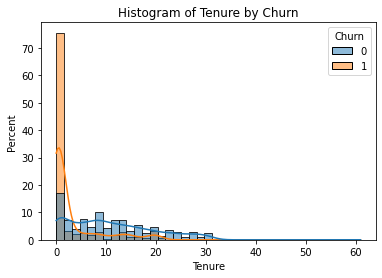

Plotting CityTier: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


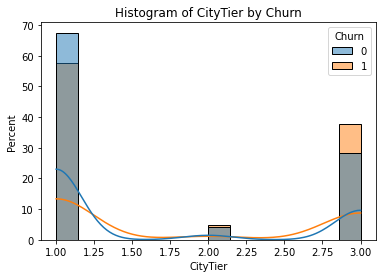

Plotting WarehouseToHome: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


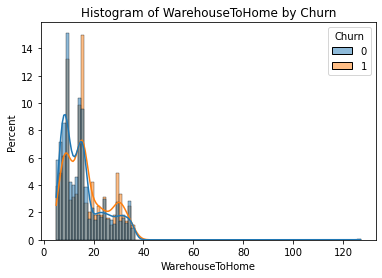

Plotting HourSpendOnApp: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


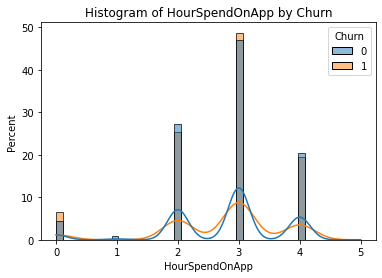

Plotting NumberOfDeviceRegistered: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


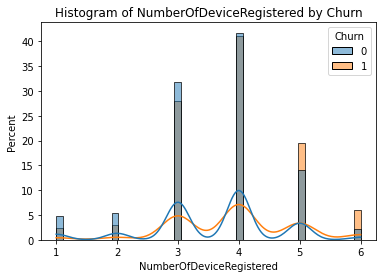

Plotting SatisfactionScore: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


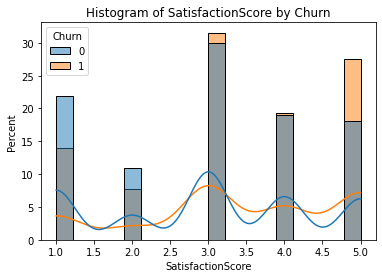

Plotting NumberOfAddress: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


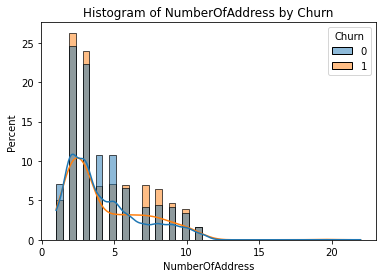

Plotting Complain: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


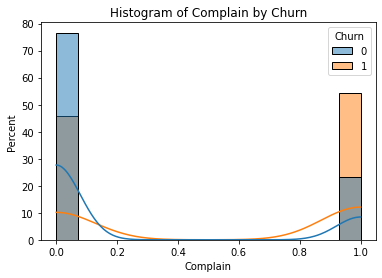

Plotting OrderAmountHikeFromlastYear: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


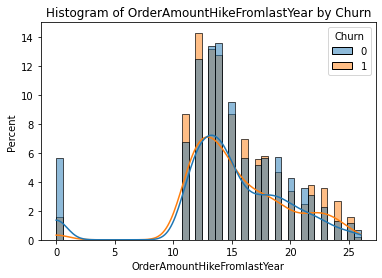

Plotting CouponUsed: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


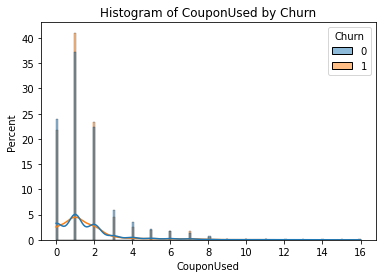

Plotting OrderCount: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


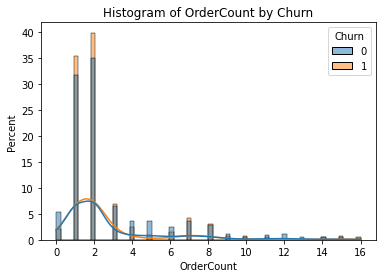

Plotting DaySinceLastOrder: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


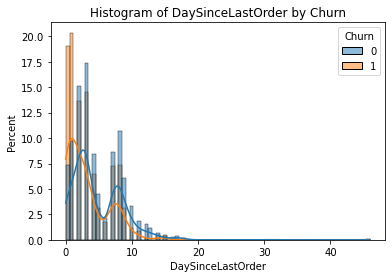

Plotting CashbackAmount: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 2)


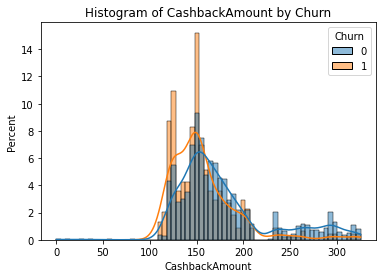

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

num_variables = ['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 
             'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 
             'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 
             'DaySinceLastOrder', 'CashbackAmount']

for value in num_variables:
    if value in df.columns:  # Ensure that the variable is a column in the DataFrame
        data = df[['Churn', value]].dropna()  # Drop NaN values

        # Debugging statement
        print(f"Plotting {value}: Data type is {type(data)} with shape {data.shape}")

        sns.histplot(data, 
                     x=value,   # Changing the variable on the x-axis
                     hue='Churn',
                     kde=True, 
                     stat='percent', 
                     common_norm=False)
        plt.title(f'Histogram of {value} by Churn')
        plt.show()
    else:
        print(f"Column '{value}' not found in DataFrame.")


Plotting Tenure: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


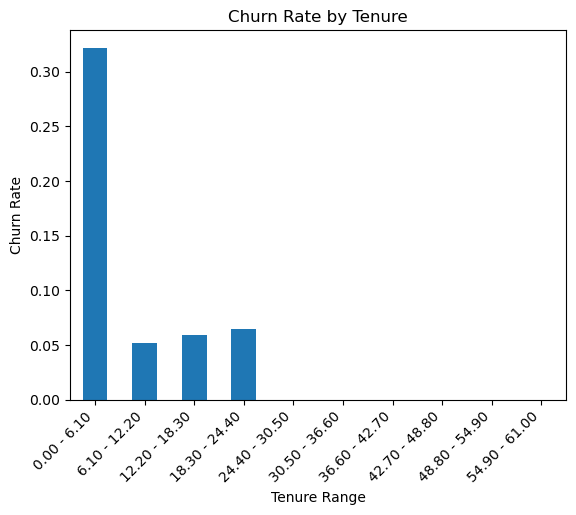

Plotting WarehouseToHome: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


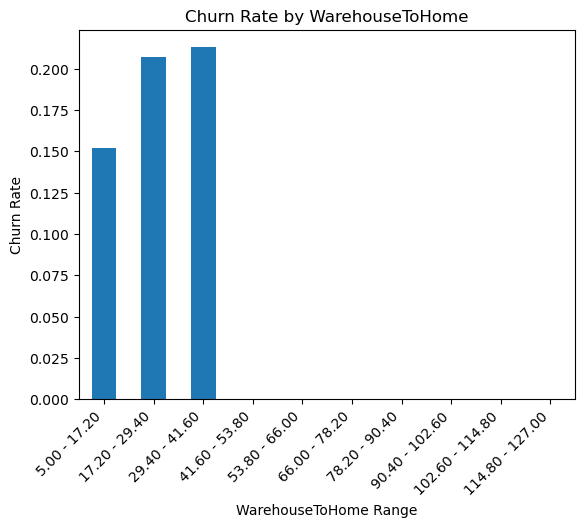

Plotting HourSpendOnApp: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


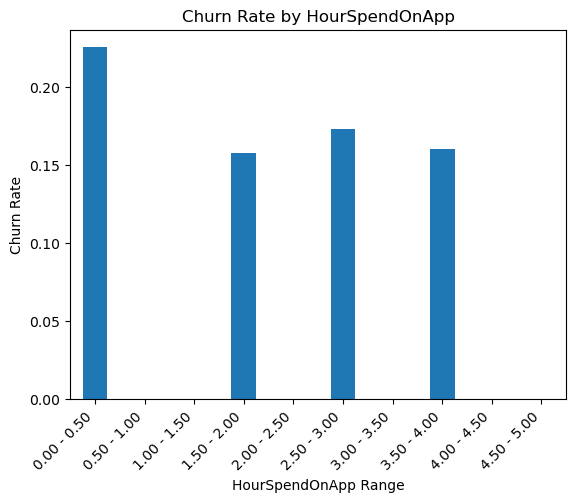

Plotting NumberOfDeviceRegistered: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


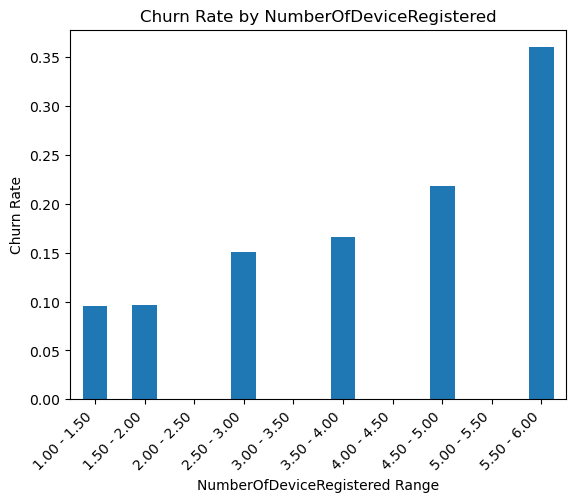

Plotting SatisfactionScore: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


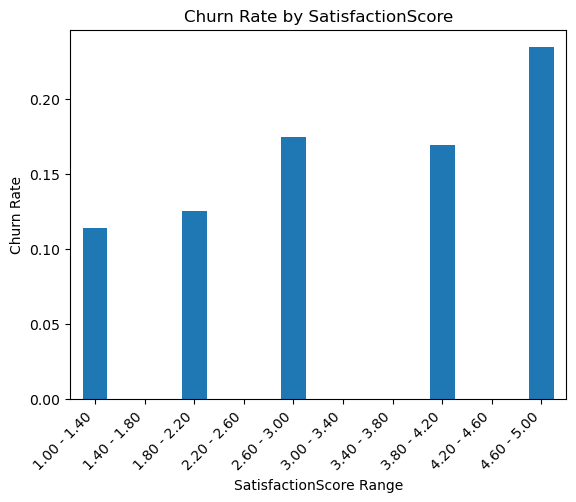

Plotting NumberOfAddress: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


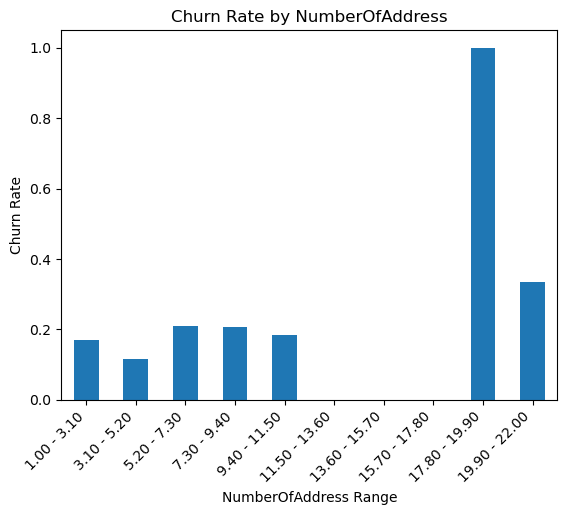

Plotting OrderAmountHikeFromlastYear: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


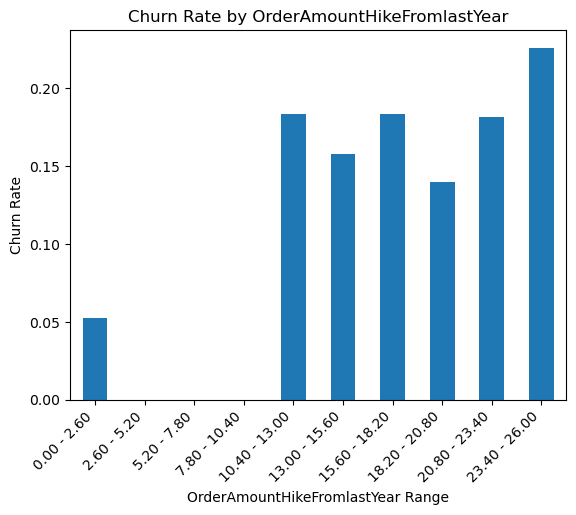

Plotting CouponUsed: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


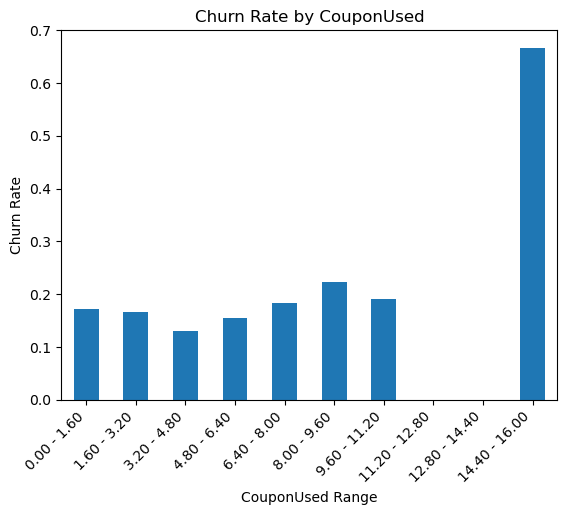

Plotting OrderCount: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


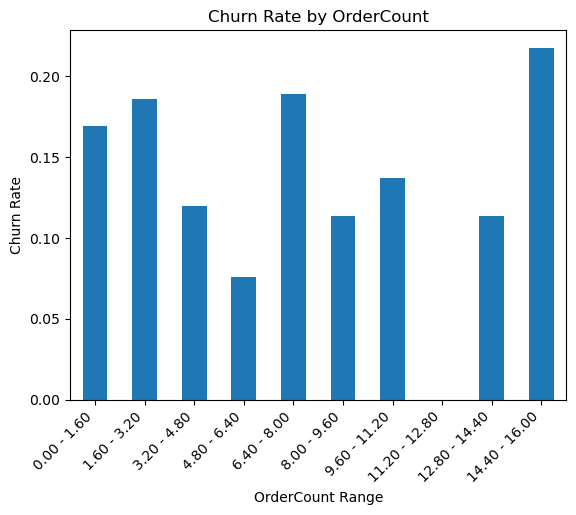

Plotting DaySinceLastOrder: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


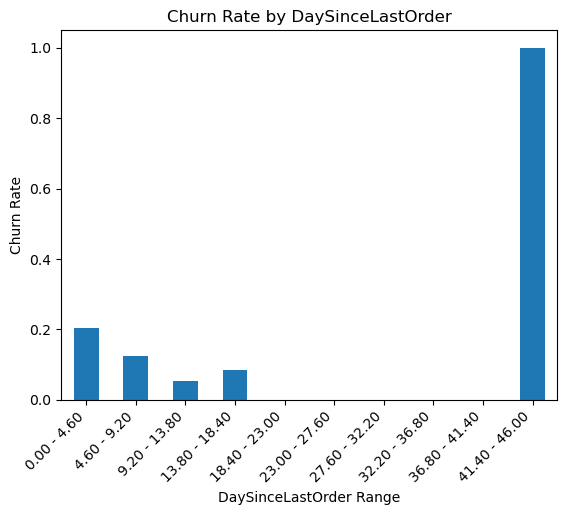

Plotting CashbackAmount: Data type is <class 'pandas.core.frame.DataFrame'> with shape (5323, 3)


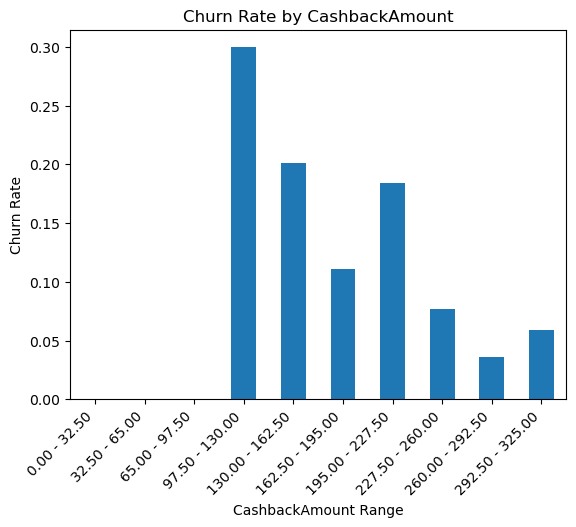

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'df' is your DataFrame and 'Churn' is a column with binary values indicating churn

num_variables = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 
                 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 
                 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 
                 'DaySinceLastOrder', 'CashbackAmount']

for value in num_variables:
    if value in df.columns:  # Ensure that the variable is a column in the DataFrame
        data = df[[value, 'Churn']].dropna()  # Drop NaN values

        # Calculate bins and bin labels for the histogram
        min_value, max_value = data[value].min(), data[value].max()
        bins = np.linspace(min_value, max_value, 11)  # 10 bins
        bin_labels = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)]
        data['bin'] = pd.cut(data[value], bins=bins, include_lowest=True, labels=bin_labels)

        # Calculate churn rate for each bin
        churn_rate = data.groupby('bin')['Churn'].sum() / data.groupby('bin')['Churn'].count()

        # Debugging statement
        print(f"Plotting {value}: Data type is {type(data)} with shape {data.shape}")

        # Bar plot of churn rate by bin
        churn_rate.plot(kind='bar')
        plt.title(f'Churn Rate by {value}')
        plt.xlabel(f'{value} Range')
        plt.ylabel('Churn Rate')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
        plt.show()
    else:
        print(f"Column '{value}' not found in DataFrame.")



### Interaction between Churn and qualitative features
<div class="alert alert-block alert-success">

 Let's analyze the most relevant insights from analyzing churn depending on categorical variables:

1. **Login Device**: The churn rate for customers using a computer to login is higher compared to those using a mobile phone. This could suggest that the user experience on computers may need improvement or that mobile users have a different engagement pattern with the platform.

2. **Payment Mode**: Customers who use 'Cash on Delivery' have a higher churn rate when logging in from a computer than a mobile phone. This could imply that the trust or satisfaction with the payment process is lower for those users. Credit Card and Debit Card users show less variance in churn rate between devices, while UPI users have a notably lower churn rate on mobile, potentially indicating a smoother experience or greater convenience on mobile platforms.

3. **Gender**: Male users show a slightly higher churn rate compared to female users across both login devices. Gender-specific marketing and customer service approaches may need to be considered to address this discrepancy.

4. **Order Category Preference**: Customers who prefer 'Mobile Phone' and 'Laptop & Accessories' have a higher churn rate, especially when logging in from a computer. This could indicate dissatisfaction with these product categories, possibly related to product expectations or service quality.

5. **Marital Status**: Single customers using a computer to login have the highest churn rate, which might reflect a more transient customer base that's exploring different platforms. Meanwhile, married customers show the least variance in churn rate between different login devices, suggesting consistent user experiences. This might suggest that married customers are more conservative and less volatile than singles. 


Plotting PreferredLoginDevice: Data type is <class 'pandas.core.series.Series'> with shape (5323,)


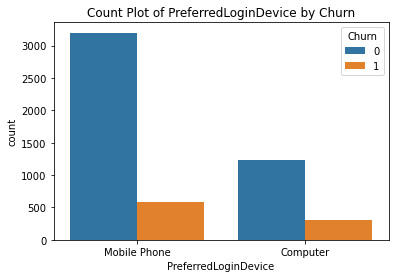

Plotting PreferredPaymentMode: Data type is <class 'pandas.core.series.Series'> with shape (5323,)


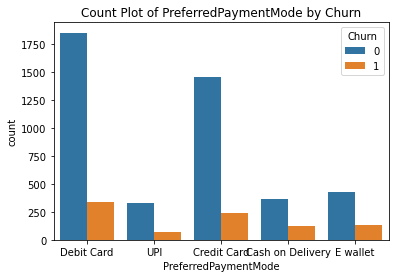

Plotting Gender: Data type is <class 'pandas.core.series.Series'> with shape (5323,)


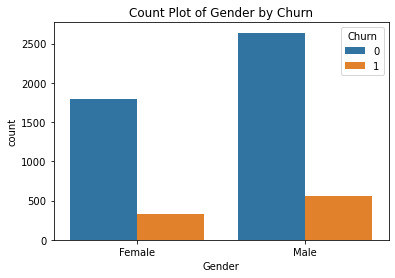

Plotting PreferedOrderCat: Data type is <class 'pandas.core.series.Series'> with shape (5323,)


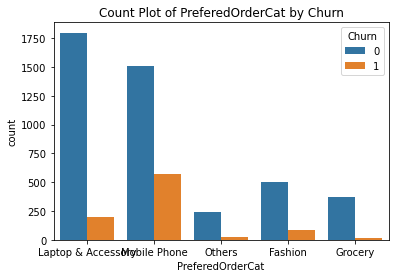

Plotting MaritalStatus: Data type is <class 'pandas.core.series.Series'> with shape (5323,)


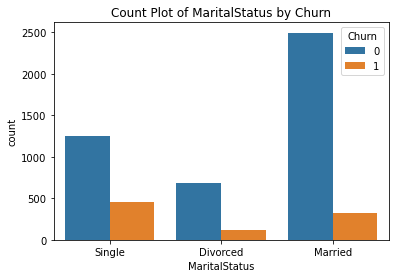

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Update this list with your categorical variables
categorical_variables = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender','PreferedOrderCat','MaritalStatus']

for value in categorical_variables:
    if value in df.columns:  # Ensure that the variable is a column in the DataFrame
        # Debugging statement
        print(f"Plotting {value}: Data type is {type(df[value])} with shape {df[value].shape}")
        data = df[['Churn', value]].dropna() 
        sns.countplot(data=df, 
                      x=value,       # Changing the variable on the x-axis
                      hue='Churn')   # Distinguishing categories by 'Churn'
        plt.title(f'Count Plot of {value} by Churn')
        plt.show()
    else:
        print(f"Column '{value}' not found in DataFrame.")


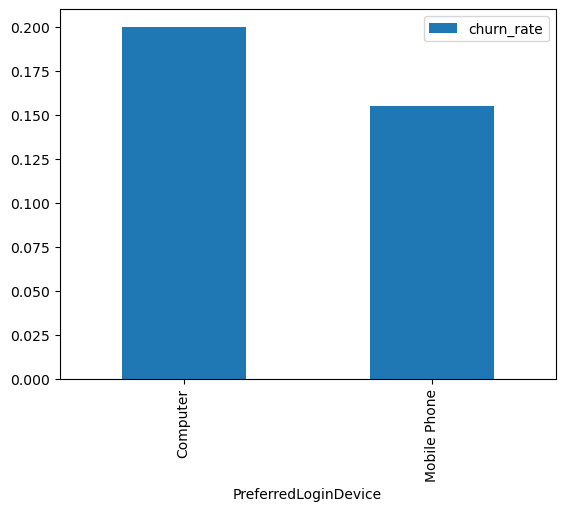

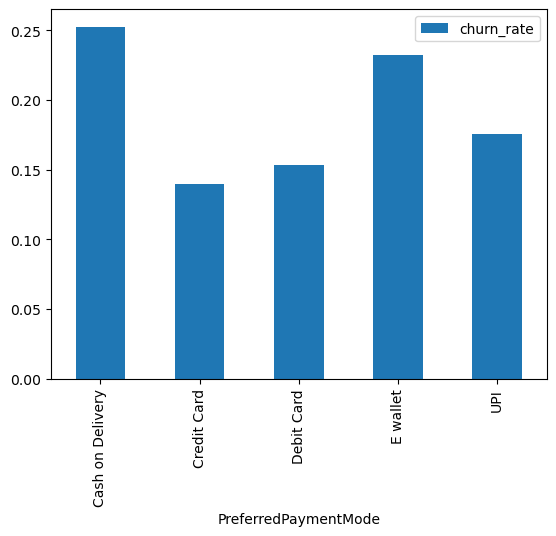

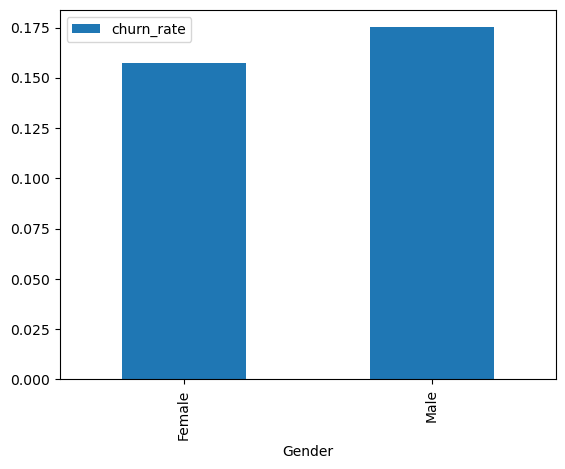

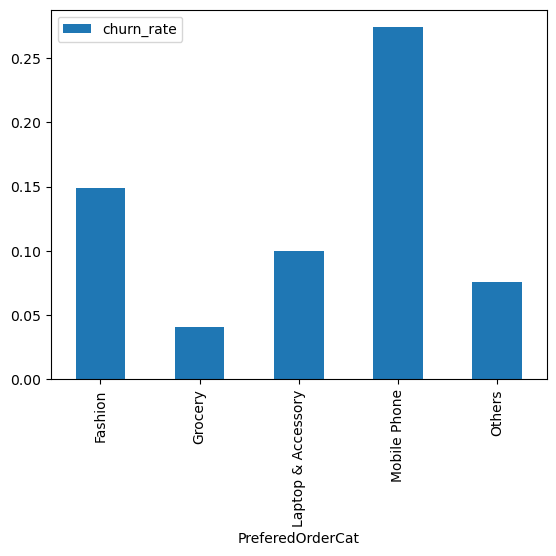

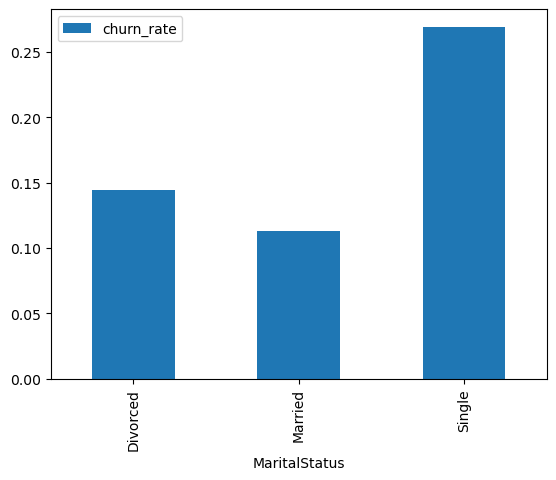

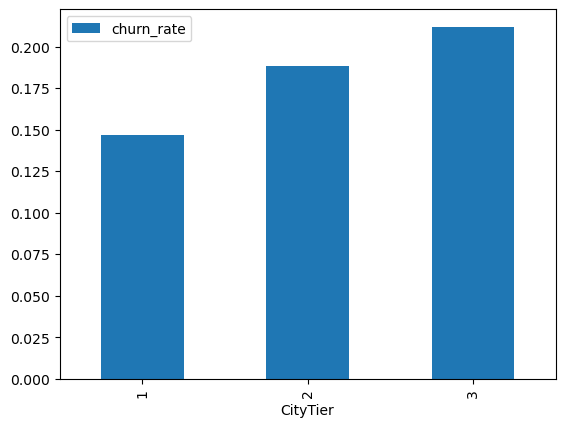

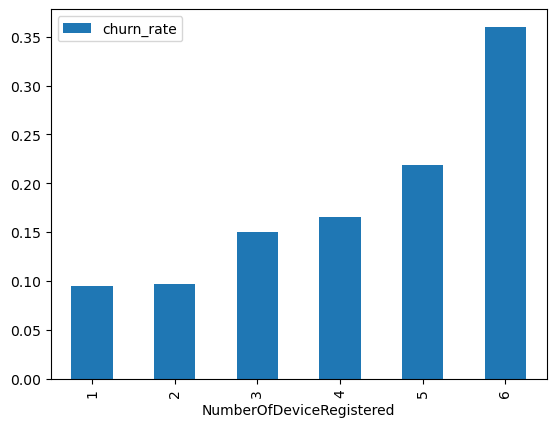

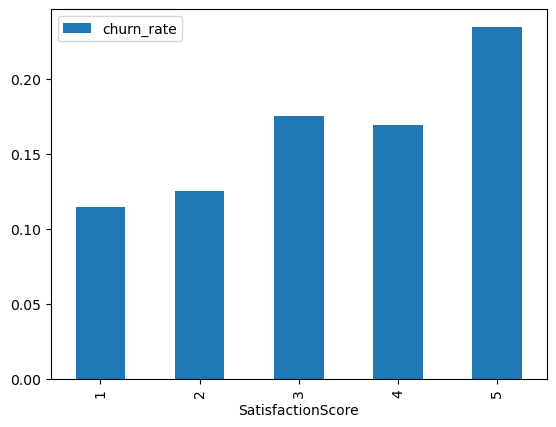

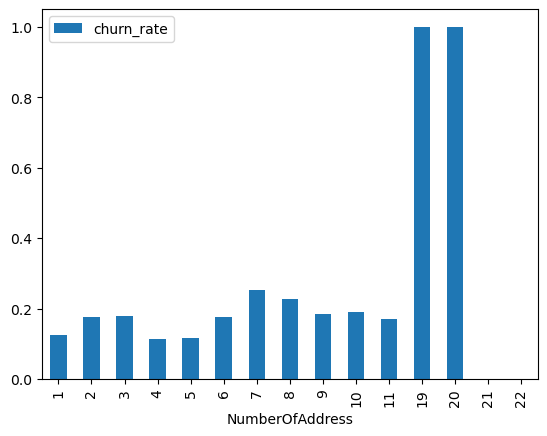

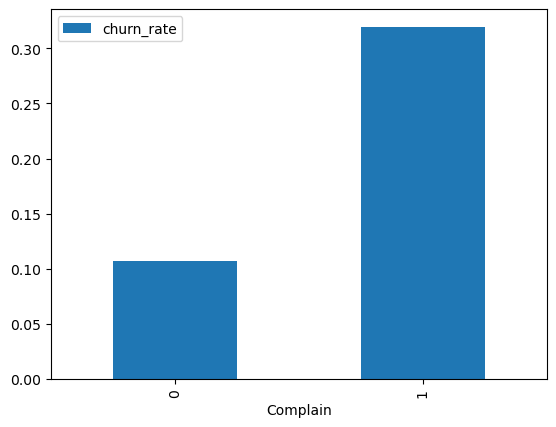

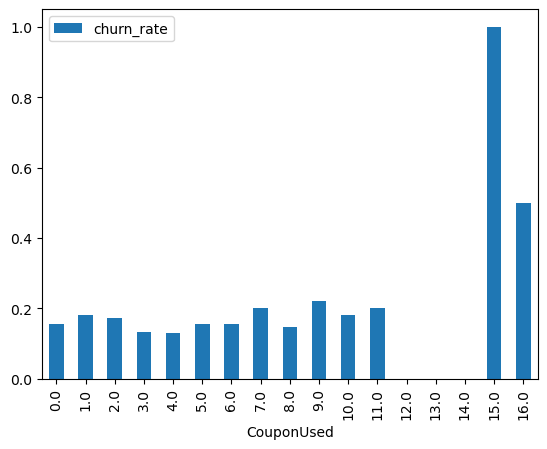

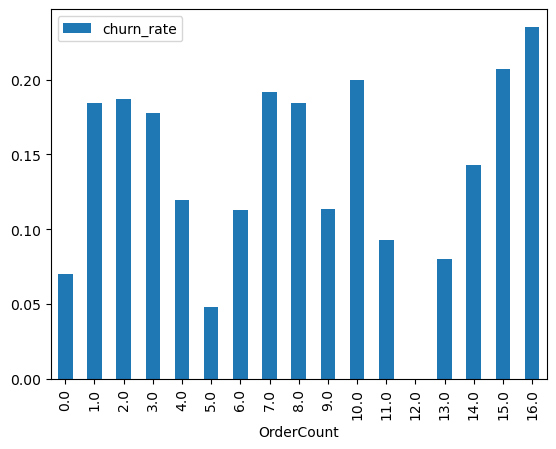

In [355]:
categorical_ordinal_variables = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender','PreferedOrderCat','MaritalStatus', 'CityTier','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','Complain','CouponUsed','OrderCount']
for column in categorical_ordinal_variables:
    grouped = df.groupby(column)['Churn'].agg(
    churn_rate=lambda x: x.sum() / x.count())
    grouped.plot(kind='bar')
    print('\n')

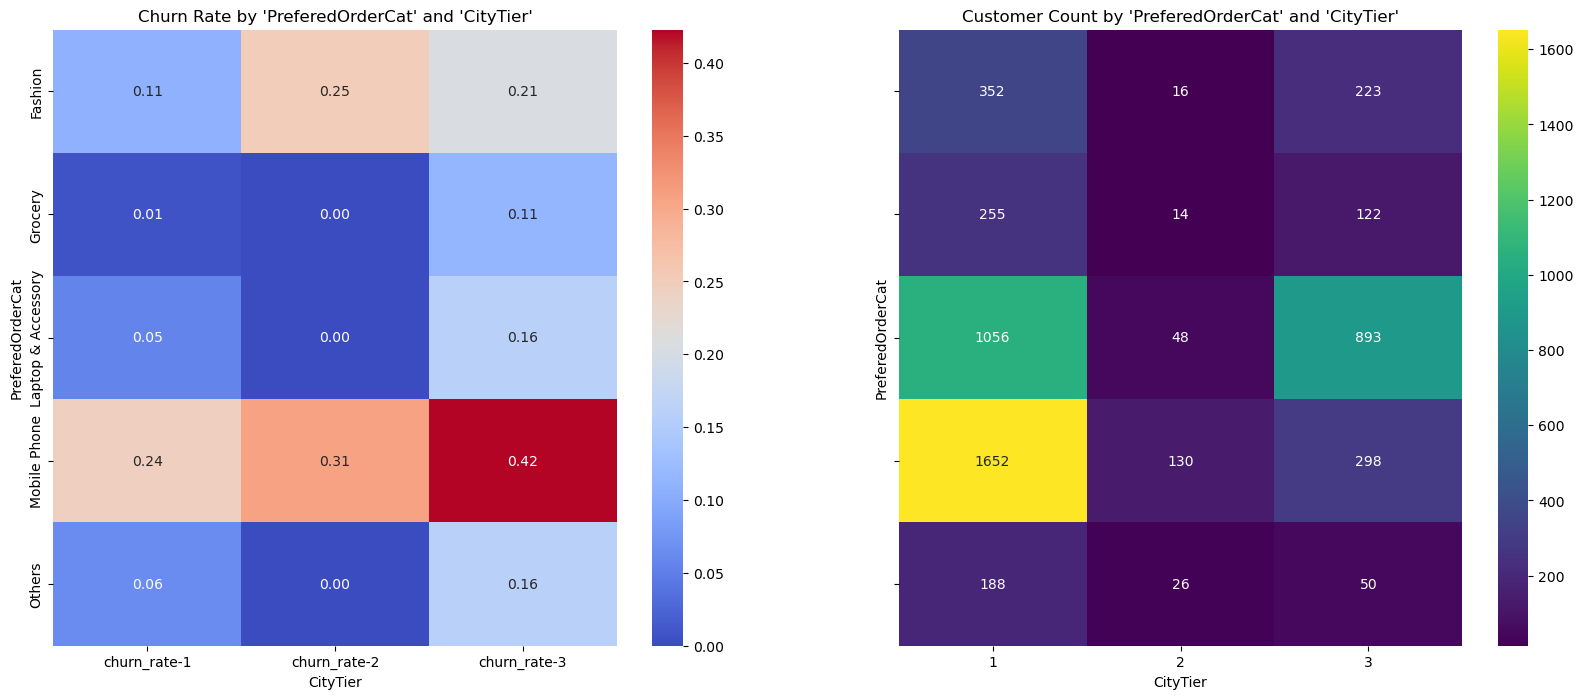

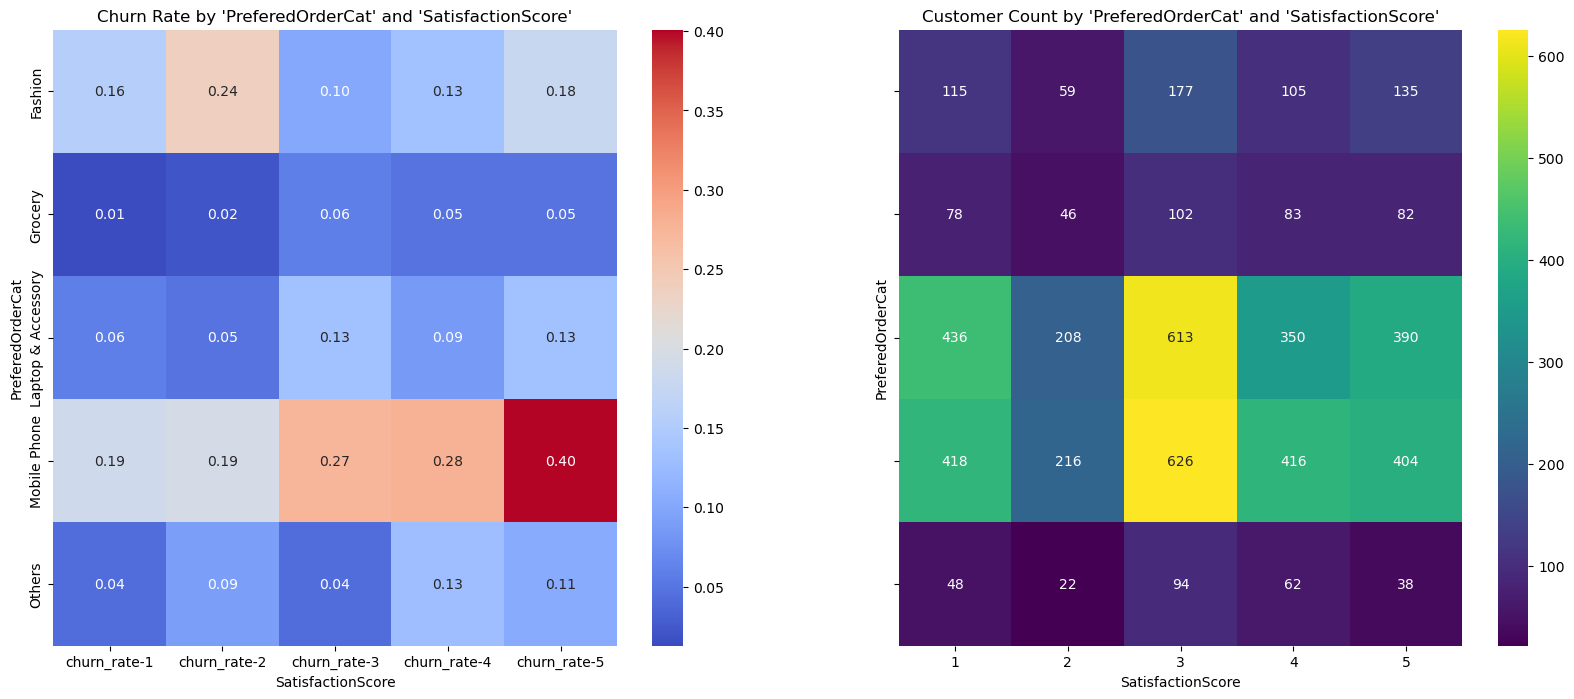

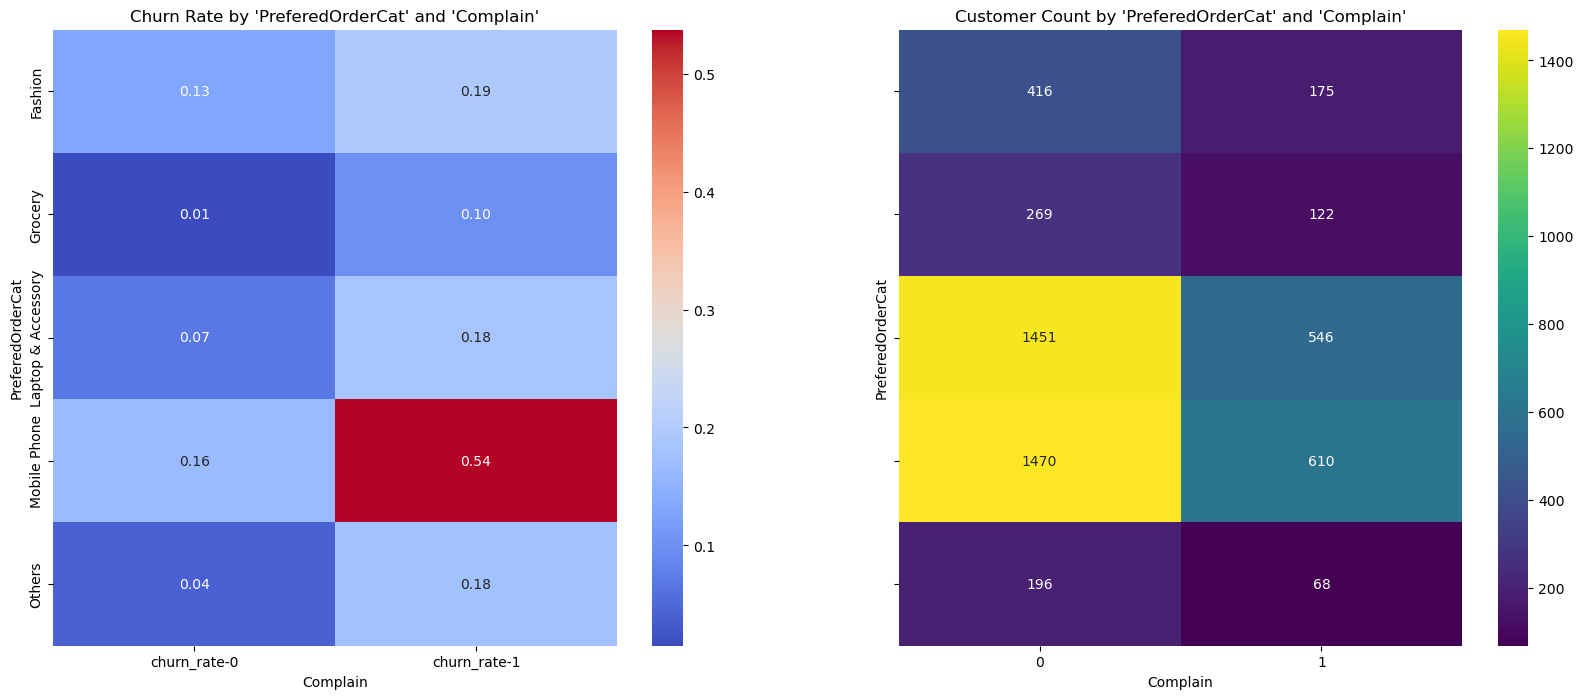

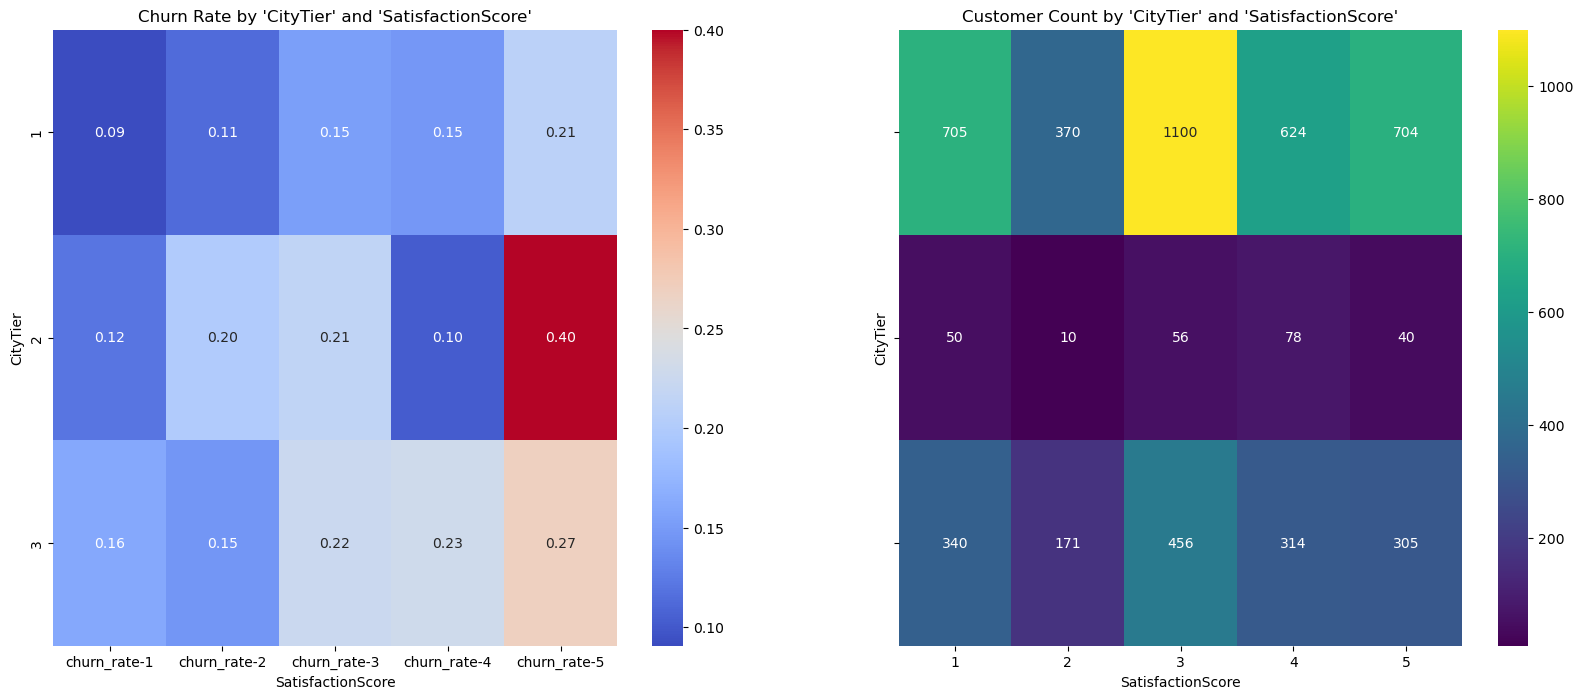

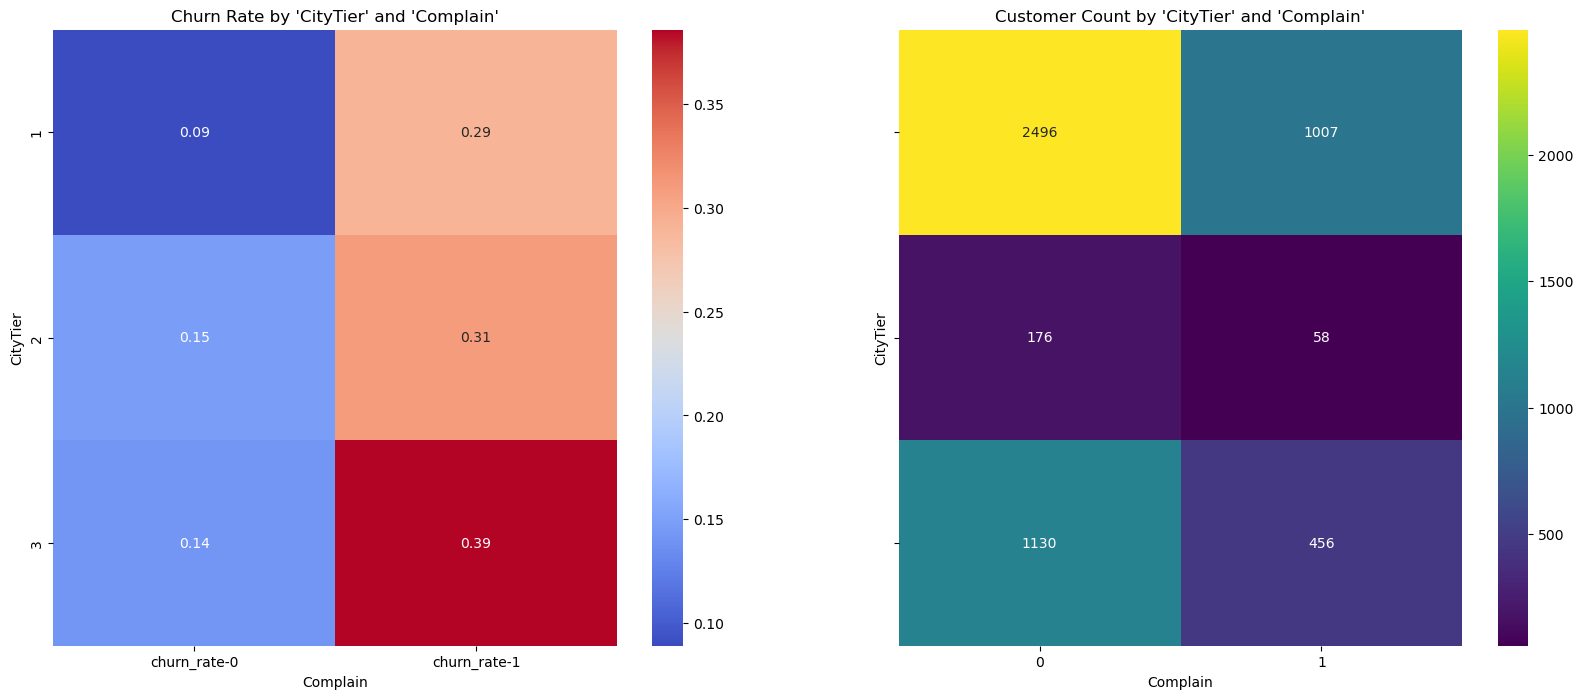

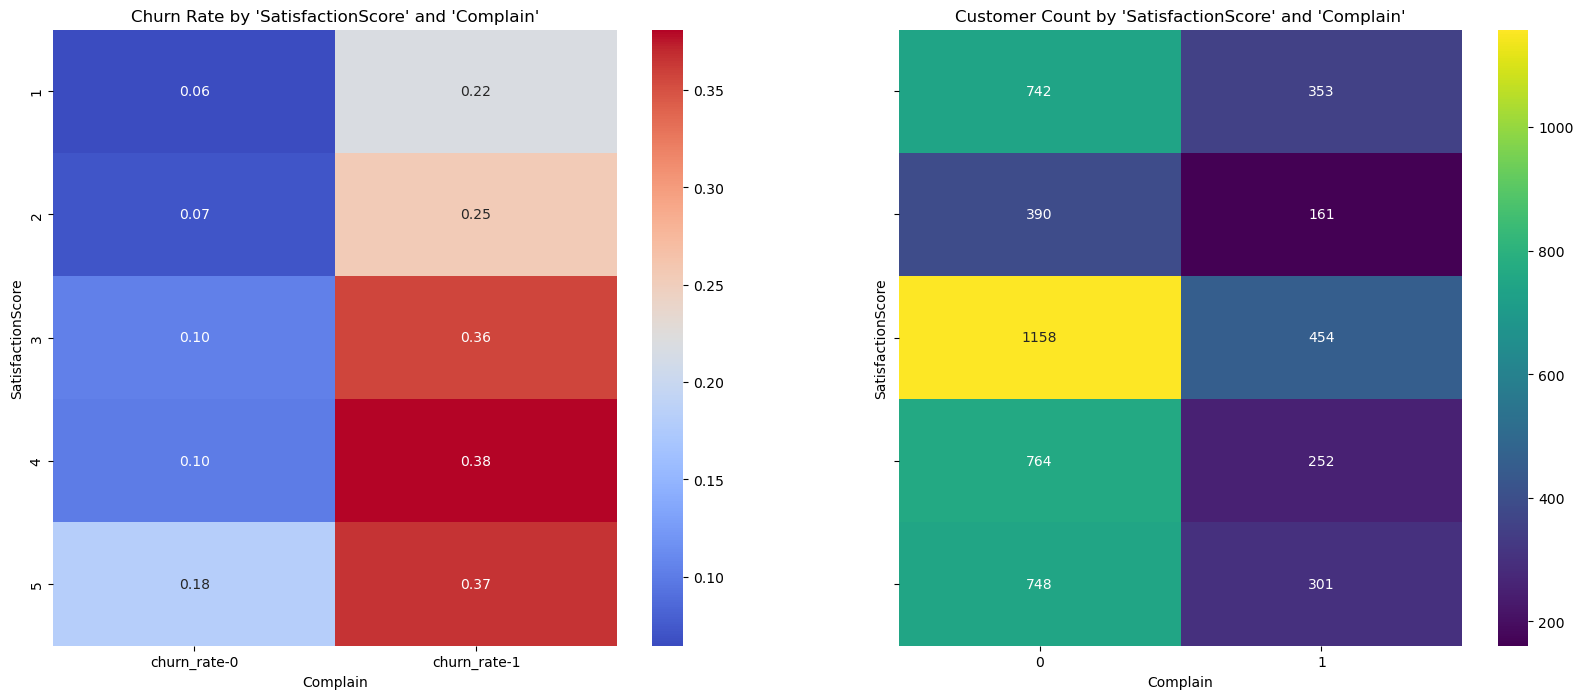

In [ ]:

from itertools import combinations

#We are only plotting the graphs that are a combination of the most relevant features. 

categorical_ordinal_variables = [ 'PreferedOrderCat', 'CityTier', 'SatisfactionScore', 'Complain']

for column, column2 in combinations(categorical_ordinal_variables, 2):
    # Calculate the churn rate
    grouped = df.groupby([column, column2])['Churn'].agg(
        churn_rate=lambda x: x.sum() / x.count()).unstack()
    
    # Count the number of customers
    count2 = df.groupby([column, column2])['Churn'].count().unstack()
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    
    # Draw the churn rate heatmap
    sns.heatmap(grouped, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[0])
    axes[0].set_title(f"Churn Rate by '{column}' and '{column2}'")
    axes[0].set_ylabel(column)
    axes[0].set_xlabel(column2)

    # Ensure count2 doesn't have NaN values and convert to integer
    count2 = count2.fillna(0).astype(int)

    # Draw the customer count heatmap
    sns.heatmap(count2, annot=True, fmt="d", cmap="viridis", cbar=True, ax=axes[1])
    axes[1].set_title(f"Customer Count by '{column}' and '{column2}'")
    axes[1].set_xlabel(column2)

    # Show the plot
    plt.show()
    
    print('\n')



# 3. Models

## Model preparation

In [61]:
#Creating the baseline model with regularization allowed
#defining the target variable
X = df.drop(columns = ['Churn']) # <- drop the y column
y = df['Churn']

### Pre-processing Steps ###
numerical_columns = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                     'NumberOfAddress', 'OrderAmountHikeFromlastYear',
                    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']  # numerical columns
onehot_columns = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']  # categorical columns for onehot encoding
encoded_ordinal_columns = ['CityTier', 'SatisfactionScore', 'Complain']        # ordinal columns already encoded, hence we will pass through them

onehot = OneHotEncoder(categories = [
                            ['Mobile Phone', 'Computer'], # PreferredLoginDevice
                            ['Debit Card', 'UPI', 'Credit Card', 'Cash on Delivery', 'E wallet'], # PreferredPaymentMode
                            ['Female', 'Male'], # Gender
                            ['Laptop & Accessory', 'Mobile Phone', 'Fashion', 'Grocery', 'Others'], #PreferedOrderCat
                            ['Single', 'Divorced', 'Married'] #PreferedOrderCat
                         ],
                         handle_unknown = 'ignore',
                        )

encoder = ColumnTransformer([
   #(nickname, encoder to apply, columns to apply to)   
    ('numerical', 'passthrough', numerical_columns),   
    ('already_encoded_ordinal', 'passthrough', encoded_ordinal_columns),             
    ('onehot', onehot, onehot_columns)                 
])


scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023, stratify = y)

## Logistic Classifier

### Degree 1

<div class="alert alert-block alert-success">
We first run the logistic regression model with degree = 1. Please note that initially, we tried to include other parameters in our grid search including polynomial degree and l1 ratio. However, the model was taking too long to run. Therefore, to run the model faster, we decided to fix the degree to 1 (we will later run this model again with degree = 2 and interaction_only = True) and l1 ratio to 0.5 (which is the general default), which are acceptable parameters. Instead, we decided to limit the grid search parameters to just regularization as we believe regularization is the most important parameter in giving us the best model.
</div>

In [233]:
# Logistic Regression Model

log = LogisticRegression(
    penalty = 'elasticnet',  
    # C = ?,          # we will let GridSearch find the best parameter
    l1_ratio = 0.5,   # we will let GridSearch find the best parameter
    solver = 'saga',         
    class_weight = 'balanced',
    max_iter = 100000
)

### Pipeline ### 
pipe_log = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('scaler', scaler),
    ('log', log)
])

### Parameters to search over ###
param_grid = {
    'log__C': [0.01, 0.1, 1, 10, 100],  
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_log = GridSearchCV(pipe_log,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_log.fit(X_train, y_train)

### Save model ###
best_model_logistic = grid_log.best_estimator_
joblib.dump(best_model_logistic, 'best_model_log.joblib')
warnings.filterwarnings('ignore')

In [234]:
y_pred_log = grid_log.predict(X_test)

print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      1329
           1       0.46      0.77      0.57       268

    accuracy                           0.81      1597
   macro avg       0.70      0.79      0.73      1597
weighted avg       0.86      0.81      0.83      1597



<div class="alert alert-block alert-success">
We see relatively good numbers with a recall of 0.77 and precision of 0.46 for churn customers. These metrics are even higher for non-churn customers. Since our metric of interest is recall, we are satisfied with these results. However, we believe that we can further improve on this model by including the interaction terms as done in the next section.
</div>

In [235]:
grid_log.best_params_

{'log__C': 0.1}

In [236]:
coefficient_logistic = pd.Series(
    index = best_model_logistic[:-1].get_feature_names_out(), # get feature names from the whole 
    data = best_model_logistic.named_steps['log'].coef_[0]
)
coefficient_logistic.sort_values(ascending = False)

already_encoded_ordinal__Complain                0.775237
numerical__NumberOfAddress                       0.648450
onehot__PreferedOrderCat_Others                  0.451477
numerical__NumberOfDeviceRegistered              0.368628
already_encoded_ordinal__SatisfactionScore       0.360989
already_encoded_ordinal__CityTier                0.321933
onehot__MaritalStatus_Single                     0.321769
numerical__WarehouseToHome                       0.295345
numerical__OrderCount                            0.282655
onehot__PreferredPaymentMode_Cash on Delivery    0.218117
onehot__PreferedOrderCat_Fashion                 0.168592
onehot__PreferredPaymentMode_E wallet            0.145951
numerical__CouponUsed                            0.104839
onehot__PreferedOrderCat_Grocery                 0.103034
onehot__Gender_Male                              0.086381
onehot__PreferredLoginDevice_Computer            0.059021
onehot__MaritalStatus_Divorced                   0.000000
numerical__Ord

In [237]:
# sorting features based on the absolute values of the coefficients
coefficient_logistic.abs().sort_values(ascending=False)

numerical__Tenure                                1.688039
already_encoded_ordinal__Complain                0.775237
numerical__NumberOfAddress                       0.648450
onehot__PreferedOrderCat_Laptop & Accessory      0.491165
onehot__PreferedOrderCat_Others                  0.451477
numerical__CashbackAmount                        0.414161
numerical__NumberOfDeviceRegistered              0.368628
already_encoded_ordinal__SatisfactionScore       0.360989
numerical__DaySinceLastOrder                     0.357815
already_encoded_ordinal__CityTier                0.321933
onehot__MaritalStatus_Single                     0.321769
numerical__WarehouseToHome                       0.295345
numerical__OrderCount                            0.282655
onehot__PreferredPaymentMode_Cash on Delivery    0.218117
onehot__PreferedOrderCat_Fashion                 0.168592
onehot__PreferredPaymentMode_E wallet            0.145951
onehot__MaritalStatus_Married                    0.134765
numerical__Cou

<div class="alert alert-block alert-success">
Based on the results above, it seems that the top 3 factors (in terms of absolute values) for customer churn are largely based on his/her tenure (negative association), complains (positive association) and the number of addresses. This makes sense as the longer the customer has been in the platform, the less likely he/she is to leave. This also agrees with our descriptive analytics done in the earlier section. As for complains, the higher the complains, the more dissatisfied our customer is and the more likely he/she is to leave. 
</div>

In [238]:
y_func_logistic = grid_log.decision_function(X_test)
prec, rec, thresh = precision_recall_curve(y_test, y_func_logistic, pos_label = True)
pr_df_logistic = pd.DataFrame(data = {
    'precision' : prec[:-1],
    'recall' : rec[:-1]
    },
    index = thresh)

pr_df_logistic

precision    recall
-13.191786   0.167815  1.000000
-10.227401   0.167920  1.000000
-8.205258    0.168025  1.000000
-8.167464    0.168130  1.000000
-8.147765    0.168236  1.000000
...               ...       ...
 4.210315    1.000000  0.018657
 4.255931    1.000000  0.014925
 4.309835    1.000000  0.011194
 4.542332    1.000000  0.007463
 7.421834    1.000000  0.003731

[1544 rows x 2 columns]

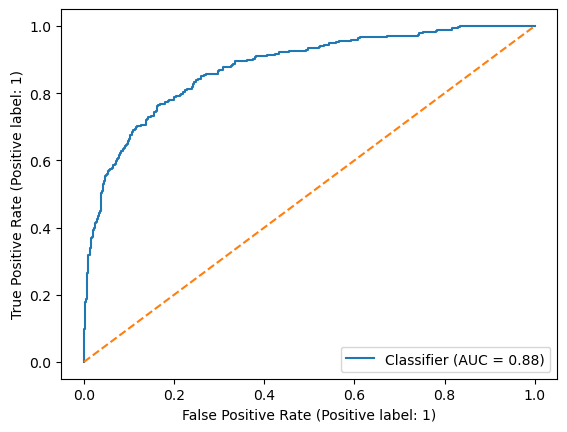

In [239]:
RocCurveDisplay.from_predictions(y_test, y_func_logistic)
plt.plot([0,1], [0,1], linestyle = 'dashed') # dummy classifier for comparison

<div class="alert alert-block alert-success">
Our model seems to be doing a lot better than a dummy model, with an AUC score of 0.88. Overall, we are satisfied with the performance of this model.
</div>

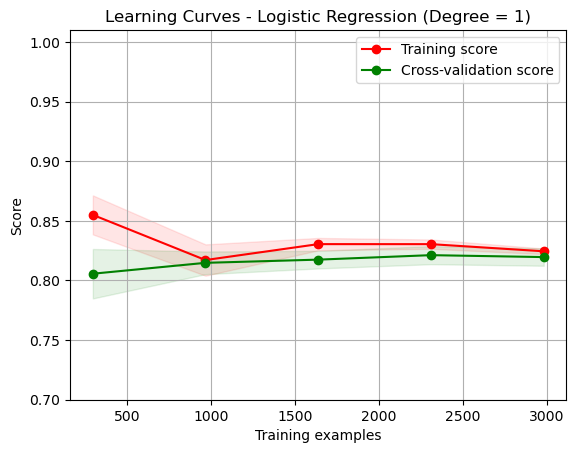

In [327]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


log = LogisticRegression(
    penalty = 'elasticnet',  
    C = 0.1,          # as found out from our grid search earlier
    l1_ratio = 0.5,  
    solver = 'saga',         
    class_weight = 'balanced',
    max_iter = 100000
)


pipe_log = Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
    ('log', log)
])


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves - Logistic Regression (Degree = 1)"
plot_learning_curve(pipe_log, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

### Degree 2

<div class="alert alert-block alert-success">
We will now run the logistic regression model with degree = 2. Please note that we limit the dimensionality to interaction_only = True as we believe the interaction terms are able to appropriately capture the non-linear impact of the independent variables (as also explained by our descriptive analytics section before), and they also make intuitive sense from a business standpoint. Furthermore, it also takes a tremendous amount of time to run logistic regression model with degrees 2 (with interaction_only = False) and 3. Therefore, due to resource constraints, we will stick to degree 2 with interaction_only = True.
</div>

In [240]:
# Logistic Regression Model

poly = PolynomialFeatures(degree=2, interaction_only=True)


log = LogisticRegression(
    penalty = 'elasticnet',  
    # C = ?,          # we will let GridSearch find the best parameter
    l1_ratio = 0.5,   # we will let GridSearch find the best parameter
    solver = 'saga',         
    class_weight = 'balanced',
    max_iter = 100000
)

### Pipeline ### 
pipe_log2 = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('poly', poly),
    ('scaler', scaler),
    ('log', log)
])

### Parameters to search over ###
param_grid = {
    'log__C': [0.01, 0.1, 1, 10, 100],  
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_log2 = GridSearchCV(pipe_log2,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_log2.fit(X_train, y_train)

### Save model ###
best_model_logistic2 = grid_log2.best_estimator_
joblib.dump(best_model_logistic2, 'best_model_log.joblib')
warnings.filterwarnings('ignore')

In [241]:
y_pred_log2 = grid_log2.predict(X_test)

print(classification_report(y_test, y_pred_log2))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1329
           1       0.58      0.82      0.68       268

    accuracy                           0.87      1597
   macro avg       0.77      0.85      0.80      1597
weighted avg       0.90      0.87      0.88      1597



<div class="alert alert-block alert-success">
We see an improvement in nearly all the metrics. Particularly, we see a slight improvement in the recall of our churn customers, and a decent improvement in the recall of non-churn customers. Precision metrics also went up. This is understandable as we had anticipated the influence of the interaction terms on customer churn in our descriptive analytics section.
</div>

In [242]:
grid_log2.best_params_

{'log__C': 1}

In [243]:
coefficient_logistic2 = pd.Series(
    index = best_model_logistic2[:-1].get_feature_names_out(), # get feature names from the whole 
    data = best_model_logistic2.named_steps['log'].coef_[0]
)
coefficient_logistic2.sort_values(ascending = False)

numerical__NumberOfAddress already_encoded_ordinal__SatisfactionScore         1.763132
numerical__NumberOfAddress already_encoded_ordinal__CityTier                  1.491960
already_encoded_ordinal__SatisfactionScore onehot__PreferedOrderCat_Others    1.488302
numerical__NumberOfDeviceRegistered numerical__NumberOfAddress                1.480584
already_encoded_ordinal__CityTier already_encoded_ordinal__Complain           1.298821
                                                                                ...   
numerical__Tenure numerical__NumberOfDeviceRegistered                        -1.121797
numerical__OrderCount onehot__PreferedOrderCat_Grocery                       -1.272690
numerical__NumberOfAddress numerical__CashbackAmount                         -1.442918
numerical__NumberOfAddress numerical__OrderAmountHikeFromlastYear            -1.541542
numerical__Tenure already_encoded_ordinal__SatisfactionScore                 -2.090050
Length: 466, dtype: float64

In [244]:
# sorting features based on the absolute values of the coefficients
coefficient_logistic2.abs().sort_values(ascending=False)

numerical__Tenure already_encoded_ordinal__SatisfactionScore                  2.090050
numerical__NumberOfAddress already_encoded_ordinal__SatisfactionScore         1.763132
numerical__NumberOfAddress numerical__OrderAmountHikeFromlastYear             1.541542
numerical__NumberOfAddress already_encoded_ordinal__CityTier                  1.491960
already_encoded_ordinal__SatisfactionScore onehot__PreferedOrderCat_Others    1.488302
                                                                                ...   
already_encoded_ordinal__CityTier onehot__PreferedOrderCat_Fashion            0.000000
already_encoded_ordinal__CityTier onehot__MaritalStatus_Single                0.000000
already_encoded_ordinal__SatisfactionScore onehot__MaritalStatus_Married      0.000000
already_encoded_ordinal__Complain onehot__Gender_Male                         0.000000
onehot__MaritalStatus_Divorced onehot__MaritalStatus_Married                  0.000000
Length: 466, dtype: float64

<div class="alert alert-block alert-success">
The top 3 factors for customer churn seem to have changed now, with the interaction terms now occupying the top 3 spots (in terms of absolute values). These are tenure*satisfaction score, number of addresses*satisfaction score and number of addresses*order amount increase from last year. 
<br>
<br>
While the underlying variables stay largely the same, it seems that their interaction have much more predictive power to identify the churn customers accurately. It also means that our dataset is non-linear in nature, and hence the model with degree 2 performs better than the model with degree 1. Furthermore, we see another important variable being present here, which is the customer's satisfaction score. This factor also makes sense as the more satisfied a customer is, the less likely that he/she will churn.
</div>

In [245]:
y_func_logistic2 = grid_log2.decision_function(X_test)
prec, rec, thresh = precision_recall_curve(y_test, y_func_logistic2, pos_label = True)
pr_df_logistic2 = pd.DataFrame(data = {
    'precision' : prec[:-1],
    'recall' : rec[:-1]
    },
    index = thresh)

pr_df_logistic2

precision    recall
-35.969123   0.167815  1.000000
-35.105713   0.167920  1.000000
-32.929930   0.168025  1.000000
-32.900464   0.168130  1.000000
-29.650846   0.168236  1.000000
...               ...       ...
 12.127771   1.000000  0.018657
 12.882084   1.000000  0.014925
 13.255040   1.000000  0.011194
 13.400817   1.000000  0.007463
 14.002524   1.000000  0.003731

[1544 rows x 2 columns]

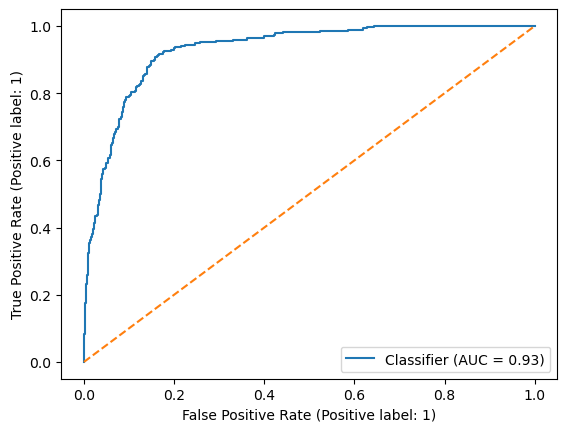

In [246]:
RocCurveDisplay.from_predictions(y_test, y_func_logistic2)
plt.plot([0,1], [0,1], linestyle = 'dashed') # dummy classifier for comparison

<div class="alert alert-block alert-success">
The AUC score also improved to 0.93 and overall, our model with degree 2 seems to be doing pretty well.
</div>

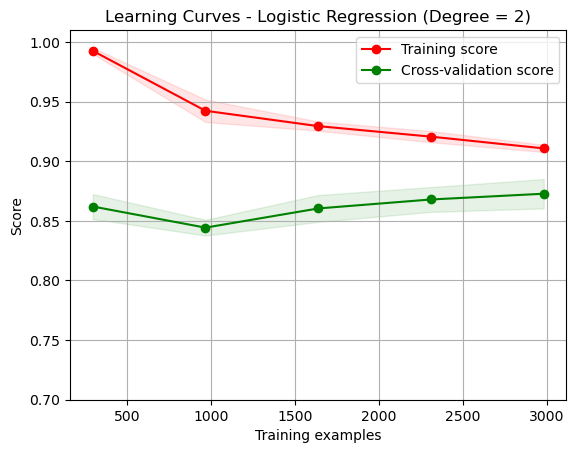

In [328]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


log = LogisticRegression(
    penalty = 'elasticnet',  
    C = 1,          # as found out from our grid search earlier
    l1_ratio = 0.5,  
    solver = 'saga',         
    class_weight = 'balanced',
    max_iter = 100000
)


pipe_log2 = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('poly', poly),
    ('scaler', scaler),
    ('log', log)
])


title = "Learning Curves - Logistic Regression (Degree = 2)"
plot_learning_curve(pipe_log2, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

## LinearSVC

### Degree 1

<div class="alert alert-block alert-success">
We will be taking a similar approach for linear SVC model as we did for the logistic regression model. We will start with a linear SVC model with degree 1, and then later try linear SVC with degree 2 and interaction_only = True.
</div>

In [248]:


# Model
svc = LinearSVC(class_weight = 'balanced', random_state = 23) # C will be searched by GridSearch

### Pipeline ### 
pipe_svc = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('scaler', scaler),
    ('svc', svc)
])

### Parameters to search over ###
param_grid = {
    #'step__param' : [list of param values]
    'svc__C': [0.01, 0.1, 1, 10, 100],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_svc = GridSearchCV(pipe_svc,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_svc.fit(X_train,y_train)

### Save model ###
best_model_svc = grid_svc.best_estimator_
joblib.dump(best_model_svc, 'best_model_svc.joblib')
warnings.filterwarnings('ignore')

In [249]:
y_pred_svc = grid_svc.predict(X_test)

print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1329
           1       0.45      0.78      0.57       268

    accuracy                           0.80      1597
   macro avg       0.70      0.79      0.72      1597
weighted avg       0.86      0.80      0.82      1597



<div class="alert alert-block alert-success">
We observed very similar metrics for linear SVC model as we did for the logistic regression model. We see a recall of 0.78 and precision of 0.45 for churn customers, while we see a recall of 0.81 and precision of 0.95 for non-churn customers. These metrics are acceptable and in line with our expectations.
</div>

In [250]:
grid_svc.best_params_

{'svc__C': 0.01}

<Axes: xlabel='decision_function', ylabel='Count'>

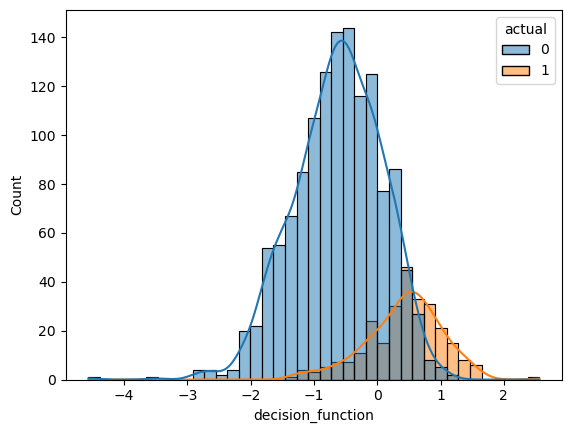

In [251]:
y_func_svc = grid_svc.decision_function(X_test)

decision_function_df = pd.DataFrame({
    'decision_function' : y_func_svc,
    'actual' : y_test
})

sns.histplot(decision_function_df, x = 'decision_function', hue = 'actual', kde = True)

<div class="alert alert-block alert-success">
With a default threshold of 0, we get a pretty good result: we are able to identify a good number of churn customers, while also correctly identifying a large chunk of our non-churn customers. Therefore, we get good true positive and true negative rates. This is why we will keep using a threshold of 0.
</div>

In [252]:
prec, rec, thresh = precision_recall_curve(y_test, y_func_svc, pos_label = True)
pr_df = pd.DataFrame(data = {
    'precision' : prec[:-1],
    'recall' : rec[:-1]
    },
    index = thresh)

pr_df

precision    recall
-4.562233   0.167815  1.000000
-3.486334   0.167920  1.000000
-2.853644   0.168025  1.000000
-2.846199   0.168130  1.000000
-2.811498   0.168236  1.000000
...              ...       ...
 1.507261   1.000000  0.018657
 1.509303   1.000000  0.014925
 1.559555   1.000000  0.011194
 1.621167   1.000000  0.007463
 2.560458   1.000000  0.003731

[1544 rows x 2 columns]

<Axes: >

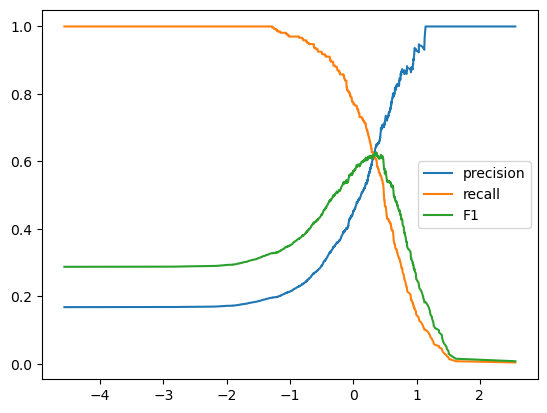

In [253]:
f1 = 2*prec*rec/(prec + rec)
pr_df['F1'] = f1[:-1]
pr_df.plot()

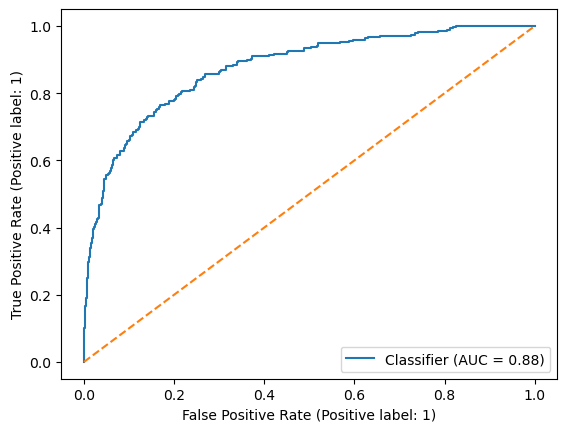

In [254]:
RocCurveDisplay.from_predictions(y_test, y_func_svc)
plt.plot([0,1], [0,1], linestyle = 'dashed') # dummy classifier for comparison

<div class="alert alert-block alert-success">
Just like for logistic model, we also notice an AUC score of 0.88, and our model seems to be doing significantly better than a dummy classifier.
</div>

In [257]:
# Get the fitted OneHotEncoder from the pipeline
encoder = best_model_svc.named_steps['encoder']
onehot_encoder = encoder.named_transformers_['onehot']

# Apply transformations to the data
X_transformed = encoder.transform(X)

# Get the feature names from OneHotEncoder for the one-hot encoded columns
onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_columns)

# Combine with the numerical and already encoded ordinal feature names
all_feature_names = numerical_columns + encoded_ordinal_columns + list(onehot_feature_names)

# Get the LinearSVC instance from the pipeline
svc = best_model_svc.named_steps['svc']

# Access the coefficients from the LinearSVC instance
coefficients = svc.coef_[0]

# Match the coefficients to the feature names
feature_coefficients = pd.Series(coefficients, index=all_feature_names)

# Print the feature coefficients
print(feature_coefficients.sort_values())


Tenure                                  -0.582572
CashbackAmount                          -0.193465
PreferedOrderCat_Laptop & Accessory     -0.170120
DaySinceLastOrder                       -0.130884
MaritalStatus_Married                   -0.070319
PreferredPaymentMode_Credit Card        -0.043116
PreferredPaymentMode_UPI                -0.034015
Gender_Female                           -0.030797
HourSpendOnApp                          -0.024529
PreferredLoginDevice_Mobile Phone       -0.018321
MaritalStatus_Divorced                  -0.017081
PreferredPaymentMode_Debit Card         -0.008261
PreferedOrderCat_Mobile Phone           -0.004622
OrderAmountHikeFromlastYear             -0.004374
PreferredLoginDevice_Computer            0.018321
Gender_Male                              0.030797
CouponUsed                               0.035784
PreferredPaymentMode_E wallet            0.042652
PreferredPaymentMode_Cash on Delivery    0.070271
PreferedOrderCat_Grocery                 0.075371


In [258]:
# sorting features based on the absolute values of the coefficients
feature_coefficients.abs().sort_values(ascending=False)

Tenure                                   0.582572
Complain                                 0.269207
NumberOfAddress                          0.220600
CashbackAmount                           0.193465
PreferedOrderCat_Others                  0.189464
PreferedOrderCat_Laptop & Accessory      0.170120
NumberOfDeviceRegistered                 0.136888
DaySinceLastOrder                        0.130884
SatisfactionScore                        0.120826
CityTier                                 0.106025
WarehouseToHome                          0.104128
OrderCount                               0.104034
MaritalStatus_Single                     0.088075
PreferedOrderCat_Fashion                 0.077035
PreferedOrderCat_Grocery                 0.075371
MaritalStatus_Married                    0.070319
PreferredPaymentMode_Cash on Delivery    0.070271
PreferredPaymentMode_Credit Card         0.043116
PreferredPaymentMode_E wallet            0.042652
CouponUsed                               0.035784


<div class="alert alert-block alert-success">
Unsurprisingly, we notice tenure, complain and number of addresses appear as top 3 factors (in terms of absolute values) influencing customer churn. These are in line with what we have observed for the logistic regression model with degree 1, and hence expected.
</div>

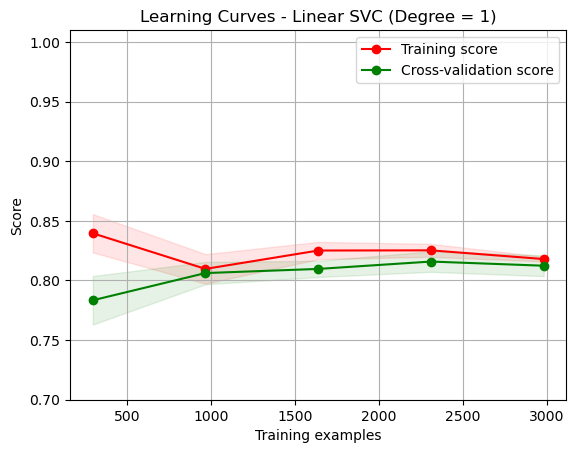

In [324]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

svc = LinearSVC(class_weight = 'balanced', 
                random_state = 23,
                C = 0.01) 

pipe_svc = Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
    ('svc', svc)
])

title = "Learning Curves - Linear SVC (Degree = 1)"
plot_learning_curve(pipe_svc, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

### Degree 2

<div class="alert alert-block alert-success">
We will now try linear SVC model with degree 2 and interaction_only = True.
</div>

In [281]:

poly = PolynomialFeatures(degree=2, interaction_only = True)

# Model
svc = LinearSVC(class_weight = 'balanced', random_state = 23) # C will be searched by GridSearch

### Pipeline ### 
pipe_svc2 = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('poly', poly),
    ('scaler', scaler),
    ('svc', svc)
])

### Parameters to search over ###
param_grid = {
    #'step__param' : [list of param values]
    'svc__C': [0.01, 0.1, 1, 10, 100],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_svc2 = GridSearchCV(pipe_svc2,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_svc2.fit(X_train,y_train)

### Save model ###
best_model_svc2 = grid_svc2.best_estimator_
joblib.dump(best_model_svc2, 'best_model_svc2.joblib')
warnings.filterwarnings('ignore')

In [282]:
y_pred_svc2 = grid_svc2.predict(X_test)

print(classification_report(y_test, y_pred_svc2))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1329
           1       0.57      0.82      0.67       268

    accuracy                           0.86      1597
   macro avg       0.76      0.85      0.79      1597
weighted avg       0.89      0.86      0.87      1597



<div class="alert alert-block alert-success">

Just like the logistic models, we see an improvement here in for linear SVC models as well in nearly all the metrics. Both the recall and precision numbers improve slightly for churn and non-churn customers as the degree 2 model is able to capture more information from the dataset.
</div>

In [283]:
grid_svc2.best_params_

{'svc__C': 0.1}

<Axes: xlabel='decision_function', ylabel='Count'>

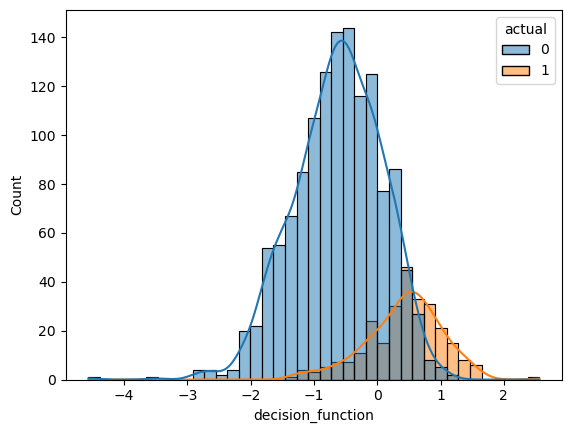

In [284]:
y_func_svc2 = grid_svc2.decision_function(X_test)

decision_function_df = pd.DataFrame({
    'decision_function' : y_func_svc,
    'actual' : y_test
})

sns.histplot(decision_function_df, x = 'decision_function', hue = 'actual', kde = True)

<div class="alert alert-block alert-success">
Just like for degree 1, with a default threshold of 0, we get a pretty good result where we are able to identify a good number of churn customers, while also correctly identifying a large chunk of our non-churn customers. Therefore, we get good true positive and true negative rates.
</div>

In [285]:
prec, rec, thresh = precision_recall_curve(y_test, y_func_svc2, pos_label = True)
pr_df = pd.DataFrame(data = {
    'precision' : prec[:-1],
    'recall' : rec[:-1]
    },
    index = thresh)

pr_df

precision    recall
-11.989502   0.167815  1.000000
-11.693480   0.167920  1.000000
-11.586708   0.168025  1.000000
-11.527614   0.168130  1.000000
-10.182685   0.168236  1.000000
...               ...       ...
 3.876011    1.000000  0.018657
 4.118370    1.000000  0.014925
 4.128853    1.000000  0.011194
 4.488428    1.000000  0.007463
 4.577635    1.000000  0.003731

[1544 rows x 2 columns]

<Axes: >

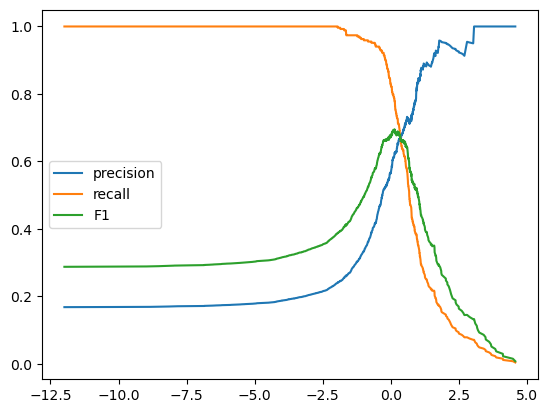

In [286]:
f1 = 2*prec*rec/(prec + rec)
pr_df['F1'] = f1[:-1]
pr_df.plot()

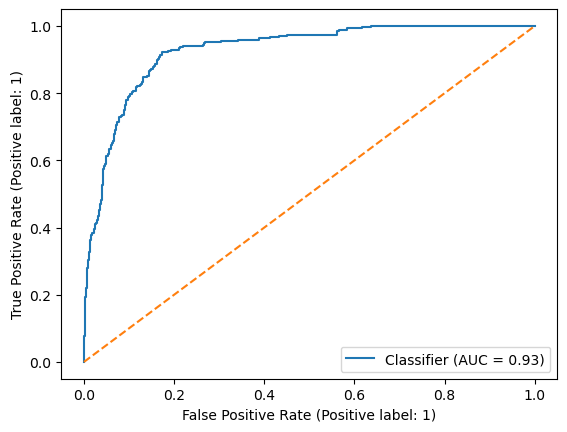

In [287]:
RocCurveDisplay.from_predictions(y_test, y_func_svc2)
plt.plot([0,1], [0,1], linestyle = 'dashed') # dummy classifier for comparison

<div class="alert alert-block alert-success">
The AUC score also improved to 0.93 and overall, our model with degree 2 seems to be doing pretty well.
</div>

In [291]:
# Existing code to get the feature names from OneHotEncoder
encoder = best_model_svc2.named_steps['encoder']
onehot_encoder = encoder.named_transformers_['onehot']
onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_columns)
all_feature_names = numerical_columns + encoded_ordinal_columns + list(onehot_feature_names)

# Adjusted code to include polynomial feature names
# Assuming 'poly' is the PolynomialFeatures instance in your pipeline
poly = best_model_svc2.named_steps['poly']
X_encoded = encoder.transform(X_train)  # Transform the original features
X_poly = poly.fit_transform(X_encoded)  # Apply polynomial transformation

# Generate polynomial feature names including the original features
poly_feature_names = poly.get_feature_names_out(input_features=all_feature_names)

# Get the LinearSVC instance from the pipeline
svc = best_model_svc2.named_steps['svc']

# Access the coefficients from the LinearSVC instance
coefficients = svc.coef_[0]

# Check if the number of coefficients matches the number of extended feature names
if len(coefficients) != len(poly_feature_names):
    raise ValueError("Number of coefficients does not match number of feature names")

# Match the coefficients to the extended feature names
feature_coefficients = pd.Series(coefficients, index=poly_feature_names)

# Print the feature coefficients
print(feature_coefficients.sort_values())


Tenure SatisfactionScore                      -0.694271
NumberOfAddress OrderAmountHikeFromlastYear   -0.511651
NumberOfAddress CashbackAmount                -0.460148
Tenure CashbackAmount                         -0.447910
OrderCount PreferedOrderCat_Grocery           -0.418651
                                                 ...   
CityTier Complain                              0.426099
NumberOfDeviceRegistered NumberOfAddress       0.473201
NumberOfAddress CityTier                       0.483635
NumberOfAddress SatisfactionScore              0.533802
SatisfactionScore PreferedOrderCat_Others      0.540404
Length: 466, dtype: float64


In [292]:
# sorting features based on the absolute values of the coefficients
feature_coefficients.abs().sort_values(ascending=False)

Tenure SatisfactionScore                                             0.694271
SatisfactionScore PreferedOrderCat_Others                            0.540404
NumberOfAddress SatisfactionScore                                    0.533802
NumberOfAddress OrderAmountHikeFromlastYear                          0.511651
NumberOfAddress CityTier                                             0.483635
                                                                       ...   
PreferedOrderCat_Laptop & Accessory PreferedOrderCat_Mobile Phone    0.000000
PreferedOrderCat_Laptop & Accessory PreferedOrderCat_Fashion         0.000000
PreferedOrderCat_Laptop & Accessory PreferedOrderCat_Grocery         0.000000
PreferedOrderCat_Laptop & Accessory PreferedOrderCat_Others          0.000000
MaritalStatus_Divorced MaritalStatus_Married                         0.000000
Length: 466, dtype: float64

<div class="alert alert-block alert-success">
Once again, we similar variables appear in top 3 factors impacting customer churn.
</div>

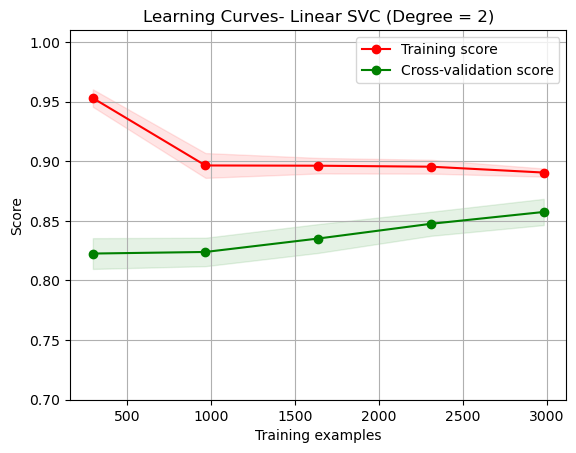

In [326]:


svc = LinearSVC(class_weight = 'balanced', 
                random_state = 23,
                C = 0.01) 

pipe_svc2 = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('poly', poly),
    ('scaler', scaler),
    ('svc', svc)
])

title = "Learning Curves- Linear SVC (Degree = 2)"
plot_learning_curve(pipe_svc2, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

# Decision Tree

In our analysis, we developed two decision tree classifiers: the first, a straightforward model, and the second, a more complex variant incorporating polynomial features of degree 2, restricted to interaction terms. This approach was informed by preliminary data analysis, which suggested varying churn rates upon interaction between different features.However, we need to take into consideration that interaction terms are inherently captured by decision trees due to the hierarchical nature of the splits—if one feature is split at the top node and another at a subsequent level, this implicitly models their interaction. 

Introducing polynomial features marginally improved accuracy, nudging it from 0.84 to 0.86. Notably, the recall for non-churning customers (churn=0) rose from 0.84 to 0.87, while, concerningly, the recall for churning customers (churn=1) dipped from 0.85 to 0.81. Given our objective to pinpoint churning customers with greater precision, this drop in recall for churn=1 is problematic.

The learning curves of the degree 1 model exhibit converging training and cross-validation scores as more data is introduced, suggesting that the model's variance isn't a significant issue, though it does hint at potential underfitting. On the other hand, the degree 2 model's learning curves show a non-converging pattern, with the training score slightly decreasing and the cross-validation score increasing as the number of training examples grows. This divergence could indicate the model's overfitting tendency, capturing noise rather than underlying data patterns.

Previous models, such as logistic regression and SVC, have shown better performance with higher-degree features, implying valuable insights might be gleaned from interaction terms not captured by a non-polynomial tree model. Nonetheless, considering the degree 2 model's complexity and our central aim, we opt to retain the degree 1 tree model and explore ensemble methods to enhance its predictive capability and encompass information that may currently be overlooked.


**Ensemble Methods used**

Our initial analysis led us to believe that the decision tree with polynomial features of degree 1 might be underfitting the data, indicating potential bias. To address this, we explored boosting methods, specifically using a Gradient Boosting Classifier. This resulted in a marked improvement in overall accuracy, which soared from 0.84 to 0.95. Furthermore, the recall for non-churning customers (churn = 0) impressively reached 0.99. Despite these gains, the recall for churning customers (churn = 1) declined to 0.78. Given our focus on accurately identifying churning customers, this decrease is counterproductive to our goals.

In search of a solution that would enhance model performance without compromising on recall for churn = 1, we turned to the Random Forest algorithm. Although typically used to combat overfitting, we adjusted the model to avoid further underfitting, while  making our model potentially more robust: 

- We set max_features to None, eliminating feature selection randomness at each split. This strategic choice was made under the presumption that our model might possess bias; therefore, under this setting each tree in the forest considers all features, making sure no information is lost. Since the random forest gives us an aggregation of many individual trees we expect most robust results than individual trees. Furthermore, we observed a more concentrated importance on the top three features in random forest compared to the more evenly distributed importance in the Gradient Boosting Classifier.

-  By using GridSearchCV to optimize tree depth and leaf nodes, we allow an appropiate level of complexity. Contrary to our single decision tree’s parameters of maximum depth 5 and maximum 15 leaf nodes, the Random Forest's best parameters were a depth of 9 and 19 leaf nodes, thus adding complexity. 

This unconventional approach yielded an increase in accuracy to 0.87 and, crucially, did not result in any drop in recall for churn = 1 while lifting the recall for churn = 0 from 0.84 to 0.87. At the last section of this project, we discovered that this model also generates the highest expected revenue per customer.


## Degree 1

In [206]:
# Decision Tree Model

tree = DecisionTreeClassifier(
    class_weight = 'balanced')

### Pipeline ### 
pipe_tree = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('scaler', scaler),
    ('tree', tree)
])

### Parameters to search over ###
param_grid = {
    #'step__param' : [list of param values]
    'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
    'tree__max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_tree = GridSearchCV(pipe_tree,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_tree.fit(X_train,y_train)

### Save model ###
best_model_tree = grid_tree.best_estimator_
joblib.dump(best_model_tree, 'best_model_tree.joblib')
warnings.filterwarnings('ignore')

In [207]:
y_pred_tree = grid_tree.predict(X_test)

print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      1329
           1       0.51      0.85      0.64       268

    accuracy                           0.84      1597
   macro avg       0.74      0.84      0.77      1597
weighted avg       0.89      0.84      0.85      1597



In [208]:
grid_tree.best_params_

{'tree__max_depth': 7, 'tree__max_leaf_nodes': 15}

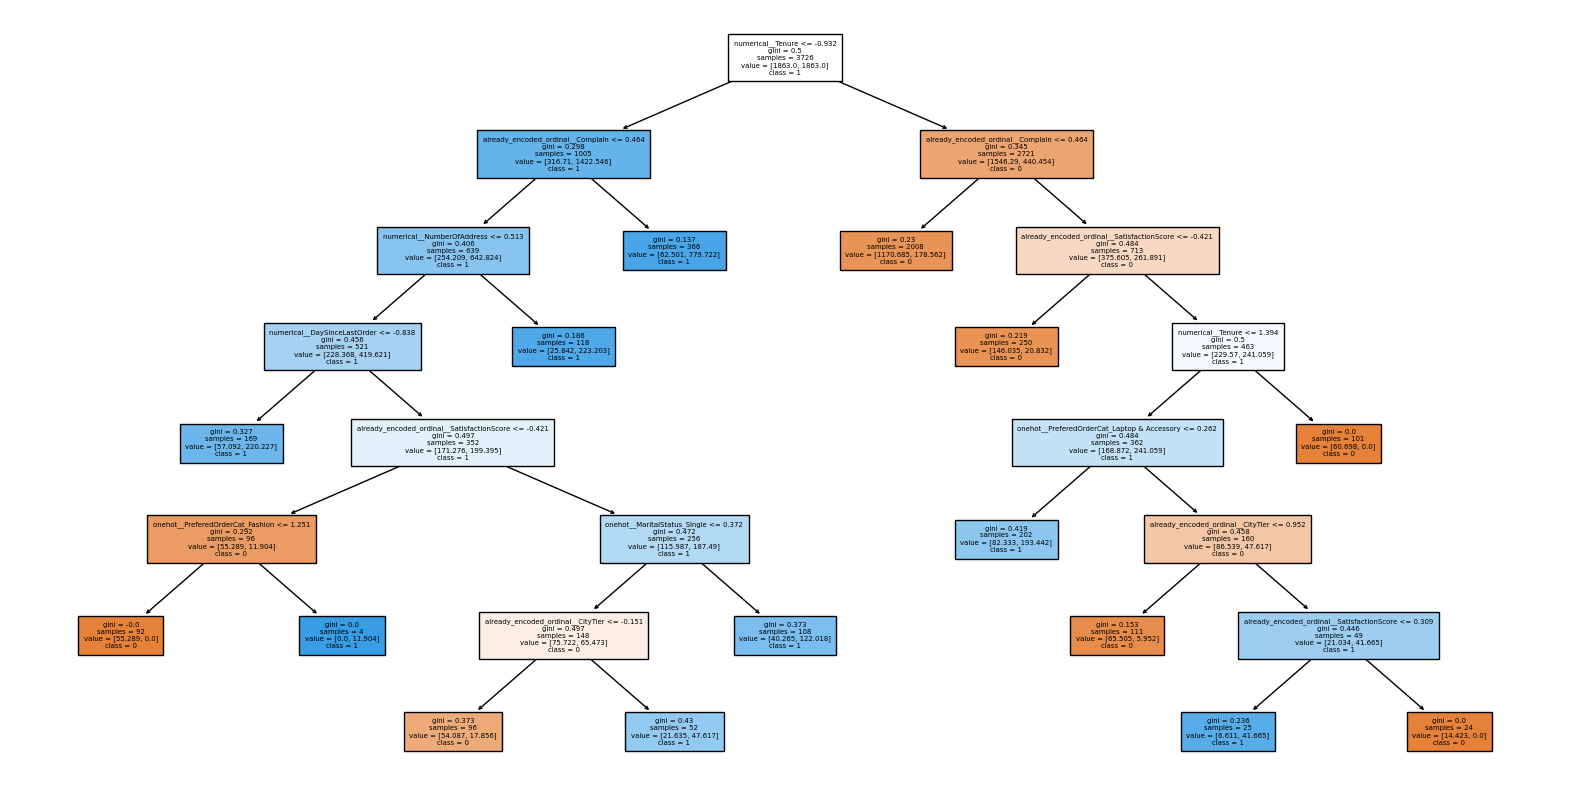

In [209]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the best decision tree model from the fitted GridSearchCV object
best_tree = best_model_tree.named_steps['tree']

# Get the feature names after transformation
# Since the tree doesn't need feature scaling and it doesn't understand the scaled data, 
# we only need to apply the encoder, not the scaler
encoder = best_model_tree.named_steps['encoder']
X_encoded = encoder.fit_transform(X_train)

# We can get feature names directly from the encoder if it's not a simple passthrough
# This assumes the encoder transforms or fits the data to provide feature names
if hasattr(encoder, 'get_feature_names_out'):
    feature_names = encoder.get_feature_names_out().tolist()  # Convert to list
else:
    # If encoder is 'passthrough', the original feature names are kept
    feature_names = X_train.columns.tolist()  # Convert to list

# Get the class names
class_names = [str(cls) for cls in best_tree.classes_]

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Set the figure size (optional)
plot_tree(
    decision_tree=best_tree,
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True,
    fontsize=5  # Adjust font size for legibility
)
plt.show()

In [210]:
coefficient_tree = pd.Series(
    index = best_model_tree[:-1].get_feature_names_out(),
    data = best_model_tree.named_steps['tree'].feature_importances_)

coefficient_tree.sort_values(ascending = False)

numerical__Tenure                                0.689683
already_encoded_ordinal__Complain                0.104224
already_encoded_ordinal__SatisfactionScore       0.074211
already_encoded_ordinal__CityTier                0.035867
numerical__NumberOfAddress                       0.022050
onehot__PreferedOrderCat_Laptop & Accessory      0.021481
numerical__DaySinceLastOrder                     0.020640
onehot__PreferedOrderCat_Fashion                 0.019416
onehot__MaritalStatus_Single                     0.012429
onehot__PreferredPaymentMode_Cash on Delivery    0.000000
onehot__PreferedOrderCat_Mobile Phone            0.000000
onehot__PreferedOrderCat_Grocery                 0.000000
onehot__PreferedOrderCat_Others                  0.000000
onehot__MaritalStatus_Divorced                   0.000000
onehot__Gender_Male                              0.000000
onehot__Gender_Female                            0.000000
onehot__PreferredPaymentMode_E wallet            0.000000
onehot__Prefer

<div class="alert alert-block alert-success">
Feature importance results are consistent with the Logistic classifier and svc models
</div>

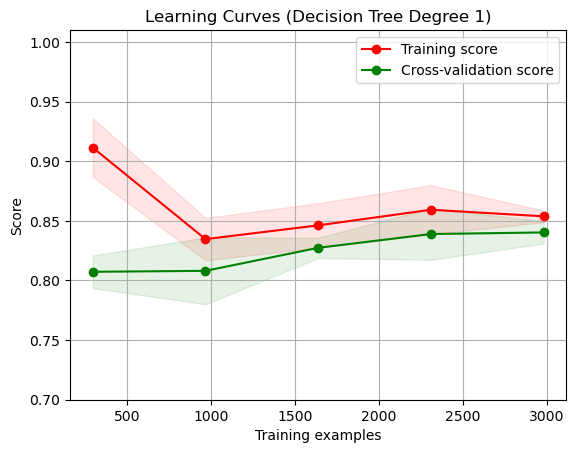

In [330]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

tree = DecisionTreeClassifier(
    max_leaf_nodes = 15,
    max_depth = 7, 
    class_weight = 'balanced')

### Pipeline ### 
pipe_tree = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('scaler', scaler),
    ('tree', tree)
])

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Decision Tree Degree 1)"
plot_learning_curve(pipe_tree, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

## Degree 2

In [212]:
# Decision Tree Model

poly = PolynomialFeatures(degree=2, interaction_only=True)

tree = DecisionTreeClassifier(
    class_weight = 'balanced')

### Pipeline ### 
pipe_tree2 = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('poly',poly),
    ('scaler', scaler),
    ('tree', tree)
])

### Parameters to search over ###
param_grid = {
    #'step__param' : [list of param values]
    'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
    'tree__max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_tree2 = GridSearchCV(pipe_tree2,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_tree2.fit(X_train,y_train)

### Save model ###
best_model_tree2 = grid_tree2.best_estimator_
joblib.dump(best_model_tree2, 'best_model_tree_2.joblib')
warnings.filterwarnings('ignore')

In [213]:
y_pred_tree2 = grid_tree2.predict(X_test)

print(classification_report(y_test, y_pred_tree2))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1329
           1       0.56      0.81      0.66       268

    accuracy                           0.86      1597
   macro avg       0.76      0.84      0.79      1597
weighted avg       0.89      0.86      0.87      1597



In [214]:
grid_tree2.best_params_

{'tree__max_depth': 5, 'tree__max_leaf_nodes': 20}

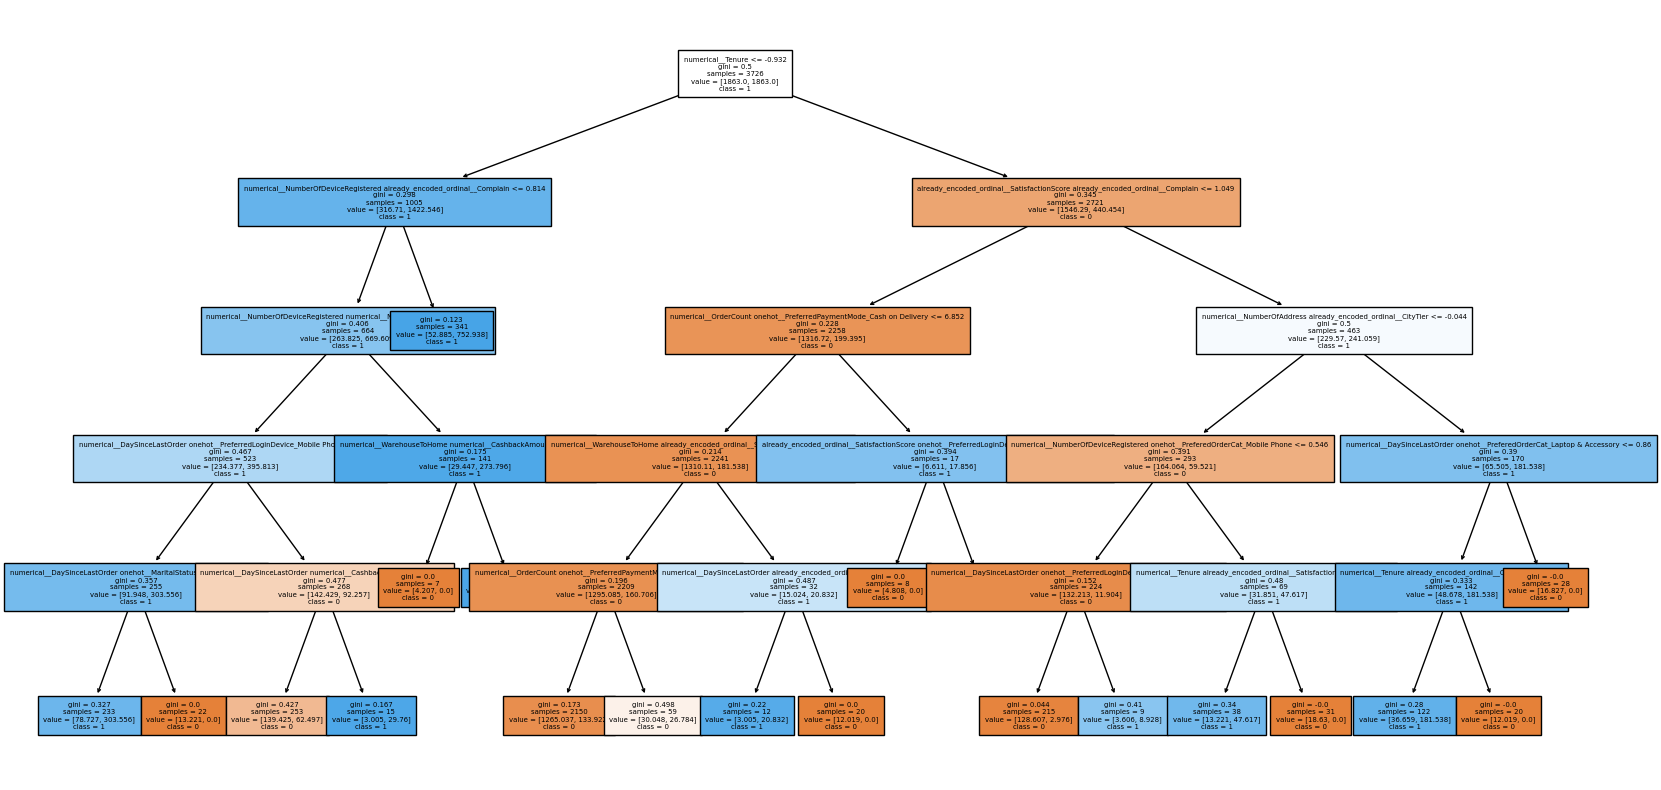

In [ ]:
# Plot the best decision tree
best_tree2 = best_model_tree2.named_steps['tree']

# Fit the encoder and transform the training data to get the feature names
X_encoded = best_model_tree2.named_steps['encoder'].fit_transform(X_train)

# Generate polynomial feature names
poly = best_model_tree2.named_steps['poly']
poly_feature_names = poly.get_feature_names_out(input_features=encoded_feature_names)

# Convert the array of feature names to a list
feature_names_list = poly_feature_names.tolist()

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Set the figure size (optional)
plot_tree(
    decision_tree=best_tree2,
    feature_names=feature_names_list,  # Use the list of feature names
    class_names=[str(cls) for cls in best_tree.classes_],
    filled=True,
    fontsize=5  # Adjust font size for legibility
)
plt.show()


In [216]:
coefficient_tree2 = pd.Series(
    index = best_model_tree2[:-1].get_feature_names_out(),
    data = best_model_tree2.named_steps['tree'].feature_importances_)

coefficient_tree2.sort_values(ascending = False)

numerical__Tenure                                                               0.583741
already_encoded_ordinal__SatisfactionScore already_encoded_ordinal__Complain    0.092166
numerical__NumberOfAddress already_encoded_ordinal__CityTier                    0.045642
numerical__DaySinceLastOrder onehot__PreferredLoginDevice_Mobile Phone          0.036561
numerical__NumberOfDeviceRegistered already_encoded_ordinal__Complain           0.036065
                                                                                  ...   
numerical__NumberOfAddress onehot__PreferredPaymentMode_Cash on Delivery        0.000000
numerical__NumberOfAddress onehot__PreferredPaymentMode_Credit Card             0.000000
numerical__NumberOfAddress onehot__PreferredPaymentMode_UPI                     0.000000
numerical__NumberOfAddress onehot__PreferredPaymentMode_Debit Card              0.000000
onehot__MaritalStatus_Divorced onehot__MaritalStatus_Married                    0.000000
Length: 466, dtype: f

<div class="alert alert-block alert-success">
Feature importance results are consistent with the Logistic classifier and svc models
</div>

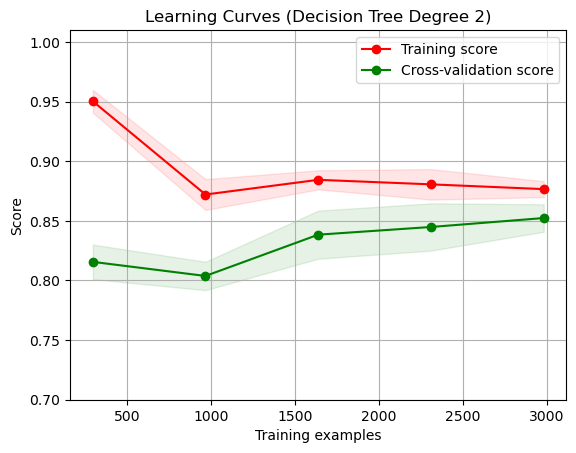

In [331]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

tree = DecisionTreeClassifier(
    max_leaf_nodes = 20,
    max_depth = 5, 
    class_weight = 'balanced')

### Pipeline ### 
pipe_tree = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('poly',poly),
    ('scaler', scaler),
    ('tree', tree)
])

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Decision Tree Degree 2)"
plot_learning_curve(pipe_tree, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

### Boosting: Gradient Boosting Classifier

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023, stratify = y)

boost = GradientBoostingClassifier(
    n_estimators = 100, 
    random_state = 23,  
)


pipe_boost = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('scaler', scaler),
    ('boost', boost)
])

### Parameters to search over ###
param_grid_boost = {
    #'step__param' : [list of param values]
    'boost__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
    'boost__max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_boost = GridSearchCV(pipe_boost,       # model to use
                    param_grid_boost, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )


grid_boost.fit(X_train, y_train)

y_pred_boost = grid_boost.predict(X_test)

print(classification_report(y_test, y_pred_boost))



              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1329
           1       0.92      0.78      0.85       268

    accuracy                           0.95      1597
   macro avg       0.94      0.88      0.91      1597
weighted avg       0.95      0.95      0.95      1597



In [229]:
grid_boost.best_params_

{'boost__max_depth': 8, 'boost__max_leaf_nodes': 20}

In [230]:
### Save model ###
best_boost = grid_boost.best_estimator_
joblib.dump(grid_boost, 'best_model_boost.joblib')
warnings.filterwarnings('ignore')

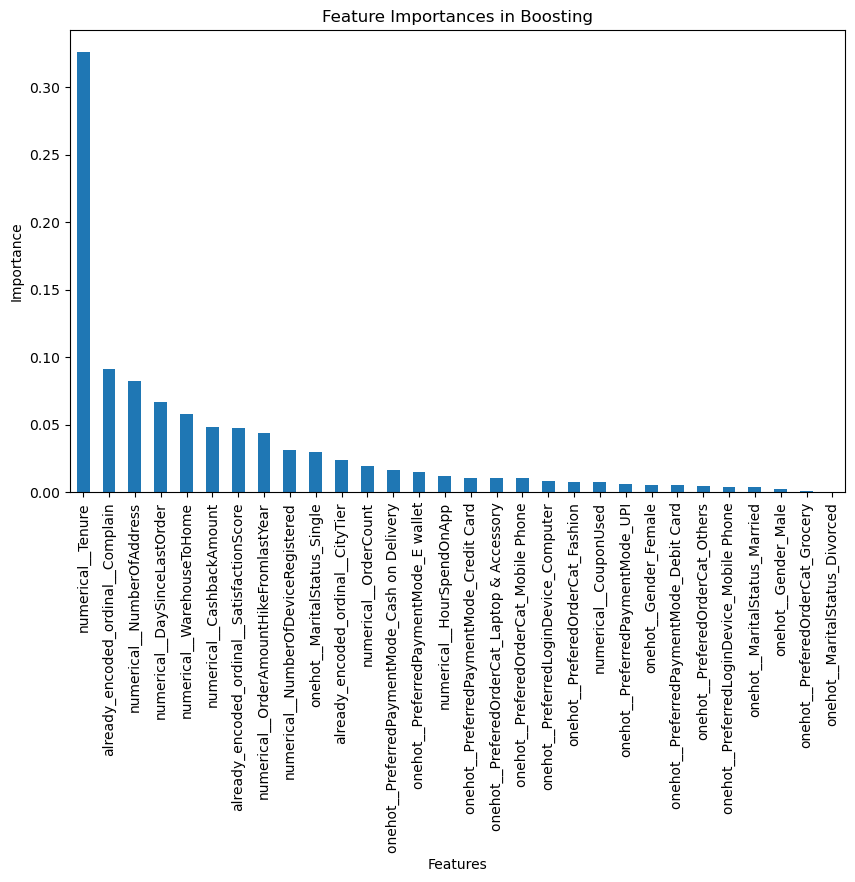

In [332]:
boosting_model = best_boost.named_steps['boost']

# Extract feature importances from the random forest model
feature_importances = boosting_model.feature_importances_

# Continue with your existing code for plotting
feature_importance_series = pd.Series(feature_importances, index=feature_names)
feature_importance_series = feature_importance_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance_series.plot(kind='bar')
plt.title('Feature Importances in Boosting')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### Bagging: Random Forest

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023, stratify = y)
rf = RandomForestClassifier(
    n_estimators = 100, # number of trees
    max_features=None,# max number of features to randomly consider at each split. We tried with None, and had better results than with sqr
                        #We do not necessarily want feature selection because degree is already = 1. We know that in general, degree = 2 perfoms slightly better overall, so we want to enforce the repetition of chosen variables
    random_state = 2023,  # random state for reproducibility
    class_weight = 'balanced'
)

pipe_forest = Pipeline([
   #(nickname, step) 
    ('encoder', encoder),
    ('scaler', scaler),
    ('rf', rf)
])

### Parameters to search over ###
param_grid_forest = {
    #'step__param' : [list of param values]
    'rf__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
    'rf__max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
}


### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_forest = GridSearchCV(pipe_forest,       # model to use
                    param_grid_forest, # parameters to search over
                    scoring = ['precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'balanced_accuracy',  # which metric to use to decide the best model
                    cv = cv,
                   )


grid_forest.fit(X_train, y_train)

y_pred_forest = grid_forest.predict(X_test)

print(classification_report(y_test, y_pred_forest))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1329
           1       0.58      0.85      0.69       268

    accuracy                           0.87      1597
   macro avg       0.77      0.86      0.80      1597
weighted avg       0.90      0.87      0.88      1597



In [223]:
grid_forest.best_params_

{'rf__max_depth': 9, 'rf__max_leaf_nodes': 19}

In [224]:
### Save model ###
best_forest = grid_forest.best_estimator_
joblib.dump(best_forest, 'best_model_forest.joblib')
warnings.filterwarnings('ignore')

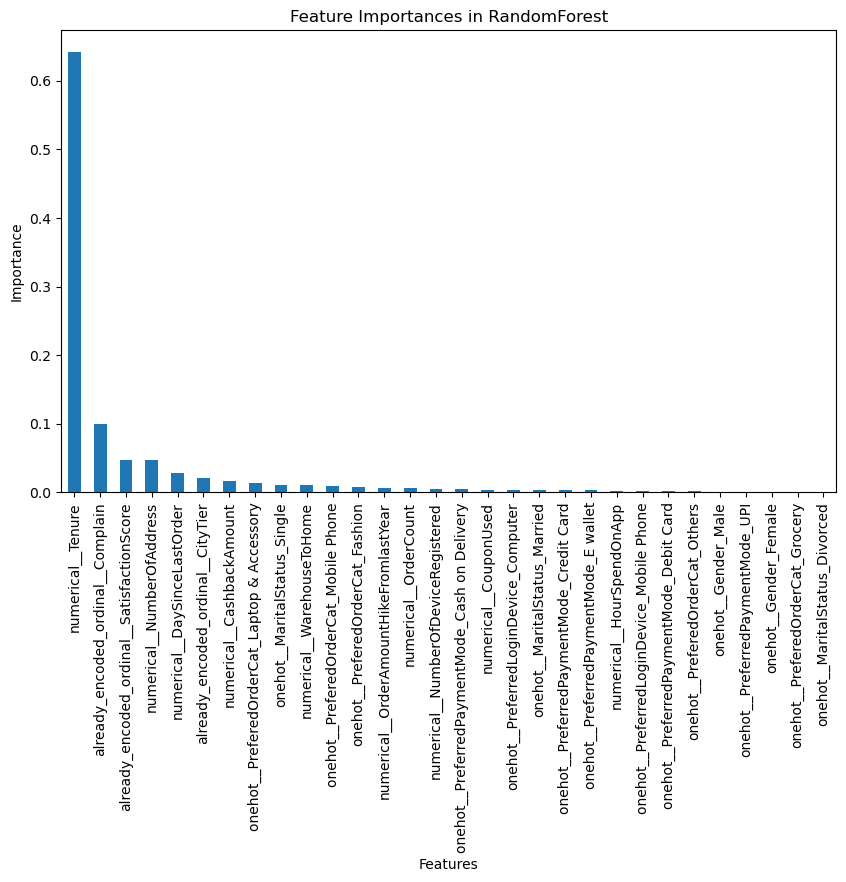

In [225]:


# Extract the RandomForestClassifier from the pipeline
random_forest_model = best_forest.named_steps['rf']

# Extract feature importances from the random forest model
feature_importances = random_forest_model.feature_importances_

# Continue with your existing code for plotting
feature_importance_series = pd.Series(feature_importances, index=feature_names)
feature_importance_series = feature_importance_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance_series.plot(kind='bar')
plt.title('Feature Importances in RandomForest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()



# 4. Expected Value & Churn Prevention


Our models must drive tangible business value to be considered effective, especially in the context of e-commerce where retention budgets form a crucial part of marketing strategies. The profitability of retention campaigns often remains ambiguous. Our aim is to leverage predictive modeling to more accurately identify customers at risk of churning. By doing so, we intend to enhance the profitability of these campaigns.

The foundation of our approach involves constructing an expected value matrix, beginning with assessing the 'Life-Time Value' (LTV) of customers we aim to retain. LTV represents the total revenue an average user is anticipated to generate over their tenure with the e-commerce platform. Although LTV is a complex metric to pinpoint, industry standards suggest a first-class LTV to be thrice the Cost of Acquiring a Customer (CAC). Given that our database's e-commerce is a market leader, we adopt this 3x CAC ratio. After analyzing average CAC across various product categories and computing an average, we deduce an approximate LTV of $203.

Our analysis reveals that customers prone to churning are typically newer to the platform. Therefore, we estimate the residual LTV of a potential churner to be 70% of the full LTV. With a budgeted expense of \\$20 per customer for the retention campaign and an anticipated 50% success rate, targeting a churn-prone customer yields an expected value of around \\$51. Conversely, engaging a customer who wasn't likely to churn results in an expected loss of \\$20. Not targeting a churn-prone customer leads to forfeiting their entire residual LTV, culminating in an expected loss of \\$142 (70% of \\$203). This comprehensive evaluation aids in assessing the the impact of retention initiatives using different churn prediction models, aligning them closely with business profitability goals. (See Excel Sheet attached to the submission)

## Value Matrix

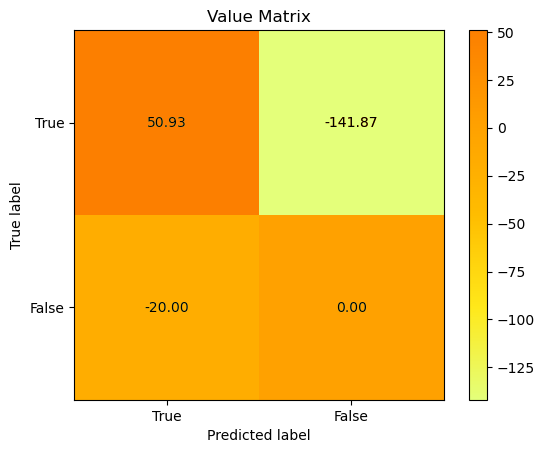

In [293]:

value_matrix = np.array([[50.93, -141.87],
                         [-20, 0]])

fig, ax = plt.subplots()

disp = ConfusionMatrixDisplay(confusion_matrix=value_matrix,
                              display_labels=['True', 'False'])

disp.plot(cmap='Wistia', ax=ax, values_format='.2f')  # values_format for 2 decimal places

plt.title('Value Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

for i in range(value_matrix.shape[0]):
    for j in range(value_matrix.shape[1]):
        ax.text(j, i, f'{value_matrix[i, j]:.2f}',
                ha="center", va="center",
                color="black")

plt.show()

<div class="alert alert-block alert-success">
Please be aware that the default strategy, in contrast to focusing on customers identified by our models as likely to churn, would be to indiscriminately target all users on our platform (as per a dummy model that always predicts churn = 1). Below is the expected value derived from this broad-stroke approach.
</div>

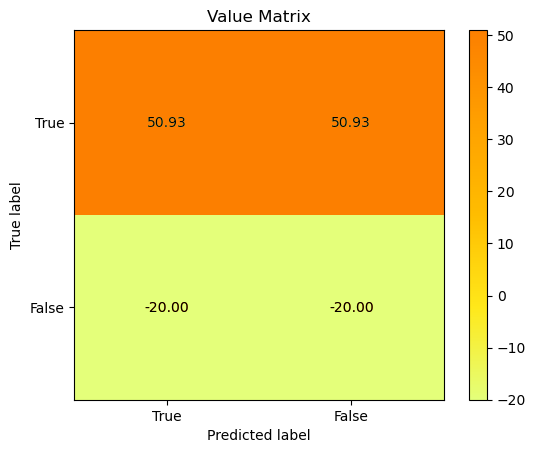

In [294]:
value_matrix_dummy = np.array([[50.93, 50.93],
                         [-20, -20]])

fig, ax = plt.subplots()

disp_dummy = ConfusionMatrixDisplay(confusion_matrix=value_matrix_dummy,
                              display_labels=['True', 'False'])

disp_dummy.plot(cmap='Wistia', ax=ax, values_format='.2f')  # values_format for 2 decimal places

plt.title('Value Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

for i in range(value_matrix_dummy.shape[0]):
    for j in range(value_matrix_dummy.shape[1]):
        ax.text(j, i, f'{value_matrix_dummy[i, j]:.2f}',
                ha="center", va="center",
                color="black")

plt.show()

In [295]:
dict_values = {'log':'','log_degree2':'','svc':'','svc_degree2':'','tree':'','tree_degree2':'','forest':'','boost':''}

## Confusion Matrix and Expected Value from each model

## Logistic Classifier

### Degree 1

Confusion Matrix Logistic Classifier Degree 1


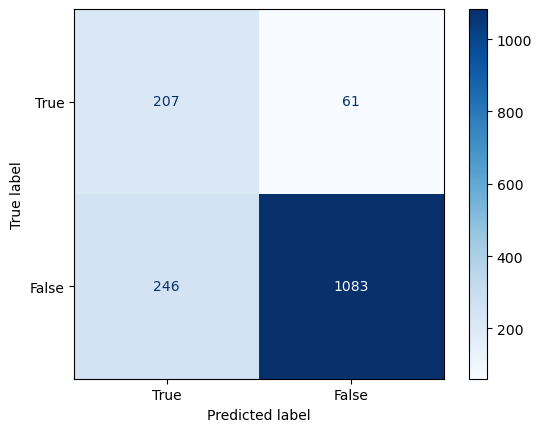

In [296]:
print('Confusion Matrix Logistic Classifier Degree 1')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_log, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

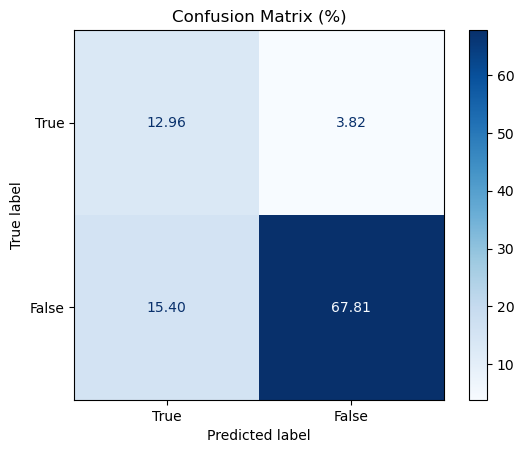

In [297]:
# Calculate the confusion matrix
cm_percentage_log = confusion_matrix(y_test, y_pred_log, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_log, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()

In [298]:
print('Expected Value per Customer:')

result_log = np.sum(value_matrix * cm_percentage_log/100)

print(round(result_log,2),'$')

dict_values['log'] = result_log

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_log = np.sum(value_matrix_dummy * cm_percentage_log/100)

print(round(result_dummy_log,2),'$')


Expected Value per Customer:
-1.9 $


Expected Value for Dummy Strategy per customer:
-8.1 $


### Degree 2

Confusion Matrix Logistic Classifier Degree 2


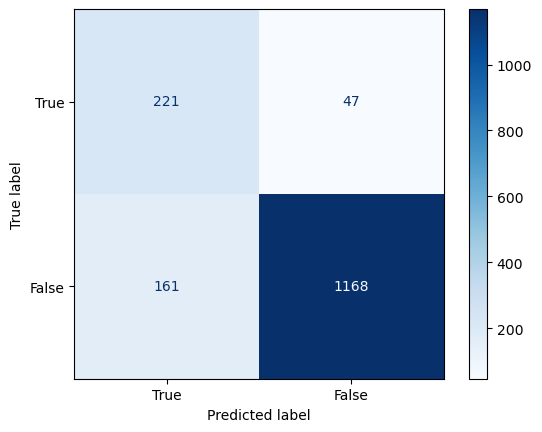

In [299]:
print('Confusion Matrix Logistic Classifier Degree 2')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_log2, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

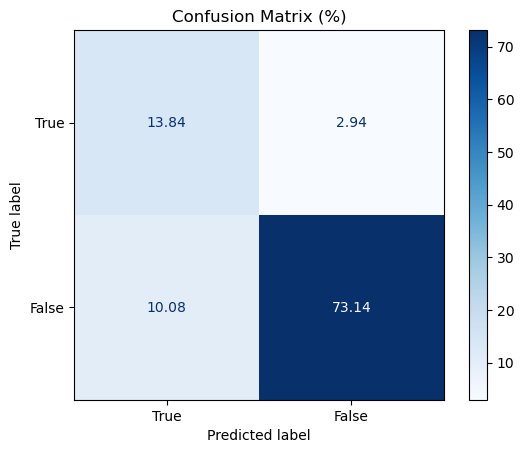

In [300]:
# Calculate the confusion matrix
cm_percentage_log2 = confusion_matrix(y_test, y_pred_log2, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_log2, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()

In [301]:
print('Expected Value per Customer:')

result_log2 = np.sum(value_matrix * cm_percentage_log2/100)

print(round(result_log2,2),'$')

dict_values['log_degree2'] = result_log2

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_log2 = np.sum(value_matrix_dummy * cm_percentage_log2/100)

print(round(result_dummy_log2,2),'$')


Expected Value per Customer:
0.86 $


Expected Value for Dummy Strategy per customer:
-8.1 $


## LinearSVC

### Degree 1

Confusion Matrix LinearSVC Degree 1


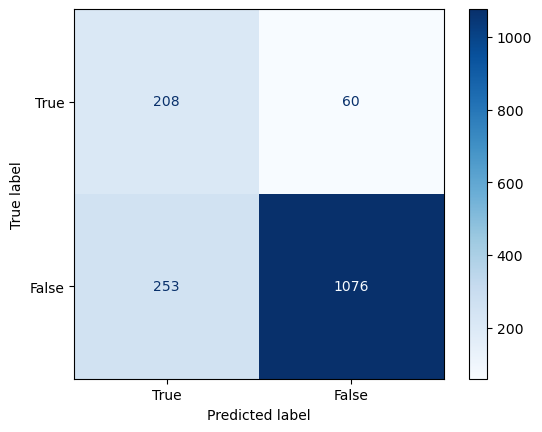

In [344]:
print('Confusion Matrix LinearSVC Degree 1')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_svc, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

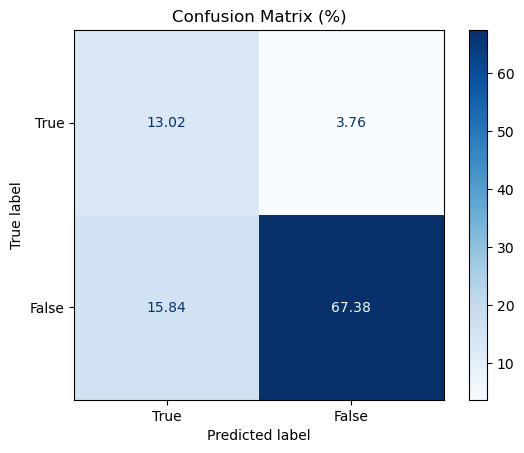

In [345]:
# Calculate the confusion matrix
cm_percentage_svc = confusion_matrix(y_test, y_pred_svc, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_svc, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()

In [346]:
print('Expected Value per Customer:')

result_svc = np.sum(value_matrix * cm_percentage_svc/100)

print(round(result_svc,2),'$')

dict_values['svc'] = result_svc

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_svc = np.sum(value_matrix_dummy * cm_percentage_svc/100)

print(round(result_dummy_svc,2),'$')

Expected Value per Customer:
-1.87 $


Expected Value for Dummy Strategy per customer:
-8.1 $


### Degree 2

Confusion Matrix SVC Degree 2


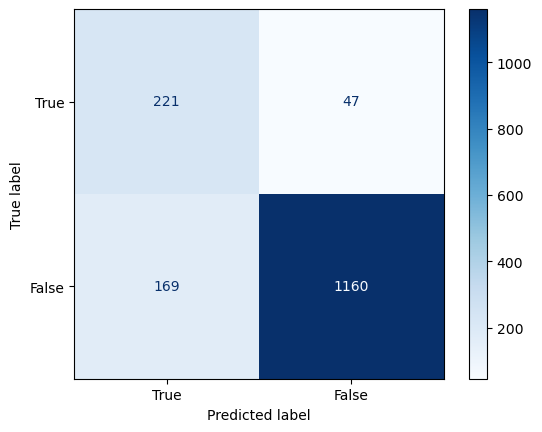

In [348]:
print('Confusion Matrix SVC Degree 2')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_svc2, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

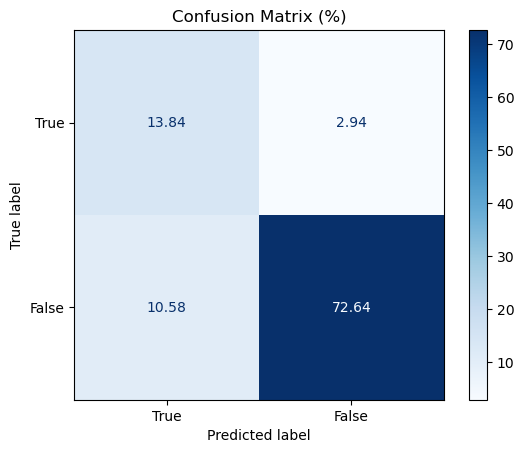

In [349]:
# Calculate the confusion matrix
cm_percentage_svc2 = confusion_matrix(y_test, y_pred_svc2, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_svc2, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()

In [350]:
print('Expected Value per Customer:')

result_svc2 = np.sum(value_matrix * cm_percentage_svc2/100)

print(round(result_svc2,2),'$')

dict_values['svc_degree2'] = result_svc2

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_svc2 = np.sum(value_matrix_dummy * cm_percentage_svc2/100)

print(round(result_dummy_svc2,2),'$')

Expected Value per Customer:
0.76 $


Expected Value for Dummy Strategy per customer:
-8.1 $


## Tree Classifiers

### Tree Degree 1

Confusion Matrix Tree Classifier


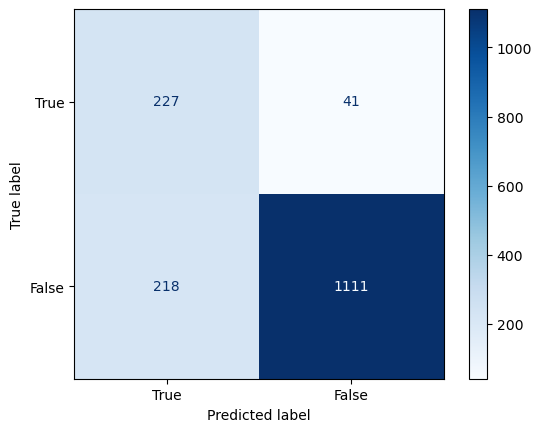

In [308]:
print('Confusion Matrix Tree Classifier')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_tree, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

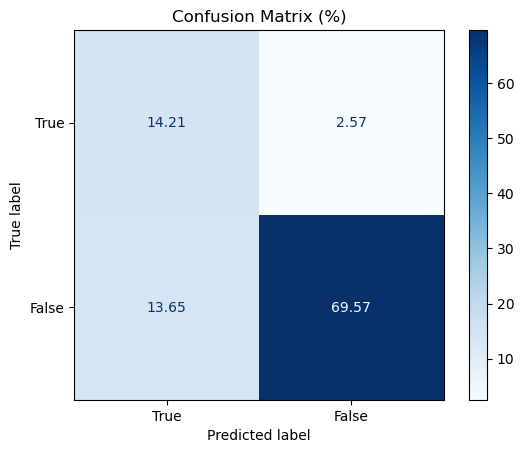

In [309]:

# Calculate the confusion matrix
cm_percentage_tree = confusion_matrix(y_test, y_pred_tree, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_tree, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()

In [310]:
print('Expected Value per Customer:')

result_tree = np.sum(value_matrix * cm_percentage_tree/100)

print(round(result_tree,2),'$')

dict_values['tree'] = result_tree

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_tree = np.sum(value_matrix_dummy * cm_percentage_tree/100)

print(round(result_dummy_tree,2),'$')

Expected Value per Customer:
0.87 $


Expected Value for Dummy Strategy per customer:
-8.1 $


### Tree Degree 2

Confusion Matrix Tree Classifier


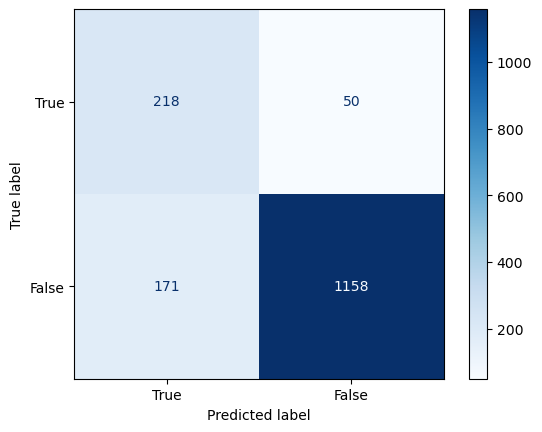

In [311]:
print('Confusion Matrix Tree Classifier')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_tree2, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

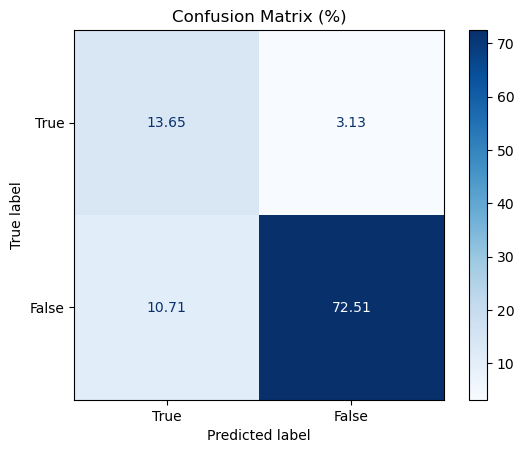

In [312]:
# Calculate the confusion matrix
cm_percentage_tree2 = confusion_matrix(y_test, y_pred_tree2, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_tree2, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()

In [313]:
print('Expected Value per Customer:')

result_tree2 = np.sum(value_matrix * cm_percentage_tree2/100)

print(round(result_tree2,2),'$')

dict_values['tree_degree2'] = result_tree

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_tree2 = np.sum(value_matrix_dummy * cm_percentage_tree2/100)

print(round(result_dummy_tree2,2),'$')

Expected Value per Customer:
0.37 $


Expected Value for Dummy Strategy per customer:
-8.1 $


### Gradient Boosting

Confusion Matrix Random Forest


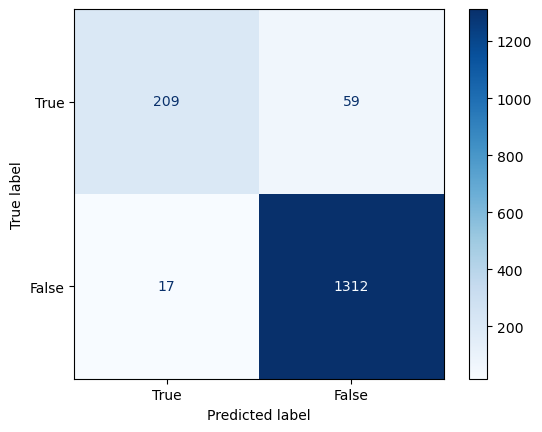

In [ ]:
print('Confusion Matrix Random Forest')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_boost, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

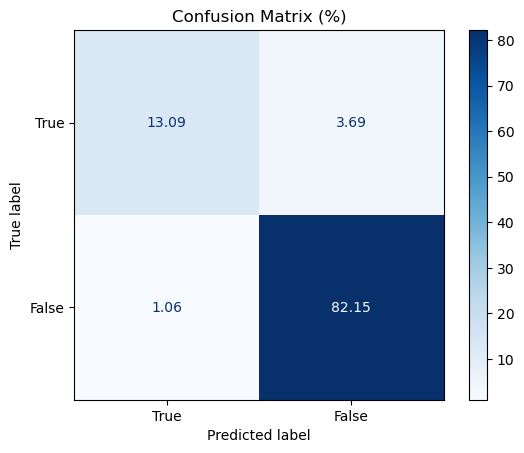

In [ ]:

# Calculate the confusion matrix
cm_percentage_boost = confusion_matrix(y_test, y_pred_boost, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_boost, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()

In [ ]:
print('Expected Value per Customer:')

result_boost = np.sum(value_matrix * cm_percentage_boost/100)

print(round(result_boost,2),'$')

dict_values['boost'] = result_boost

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_boost = np.sum(value_matrix_dummy * cm_percentage_boost/100)

print(round(result_dummy_boost,2),'$')

Expected Value per Customer:
1.21 $


Expected Value for Dummy Strategy per customer:
-8.1 $


### Random Forest

Confusion Matrix Random Forest


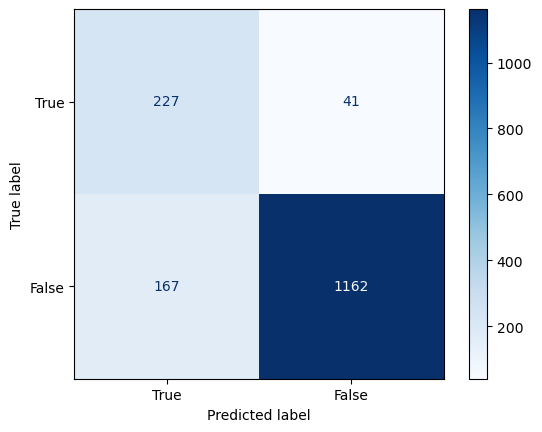

In [314]:
print('Confusion Matrix Random Forest')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_pred_forest, 
                                        labels = [True, False], 
                                        cmap = 'Blues' # colormap
                                       )

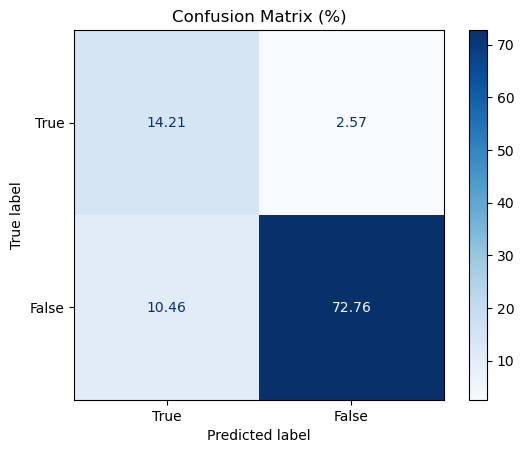

In [ ]:


# Calculate the confusion matrix
cm_percentage_forest = confusion_matrix(y_test, y_pred_forest, labels=[True, False], normalize = 'all') * 100

# Create ConfusionMatrixDisplay instance with the percentage matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage_forest, 
                              display_labels=['True', 'False'])

# Use the plot function to plot the matrix
disp.plot(cmap='Blues', values_format='.2f')  # values_format for 2 decimal places
plt.title('Confusion Matrix (%)')
plt.show()


In [316]:
print('Expected Value per Customer:')

result_forest = np.sum(value_matrix * cm_percentage_forest/100)

print(round(result_forest,2),'$')

dict_values['forest'] = result_forest

print('\n')

print('Expected Value for Dummy Strategy per customer:')

result_dummy_forest = np.sum(value_matrix_dummy * cm_percentage_forest/100)

print(round(result_dummy_forest,2),'$')


Expected Value per Customer:
1.51 $


Expected Value for Dummy Strategy per customer:
-8.1 $


### Expected Value Summary

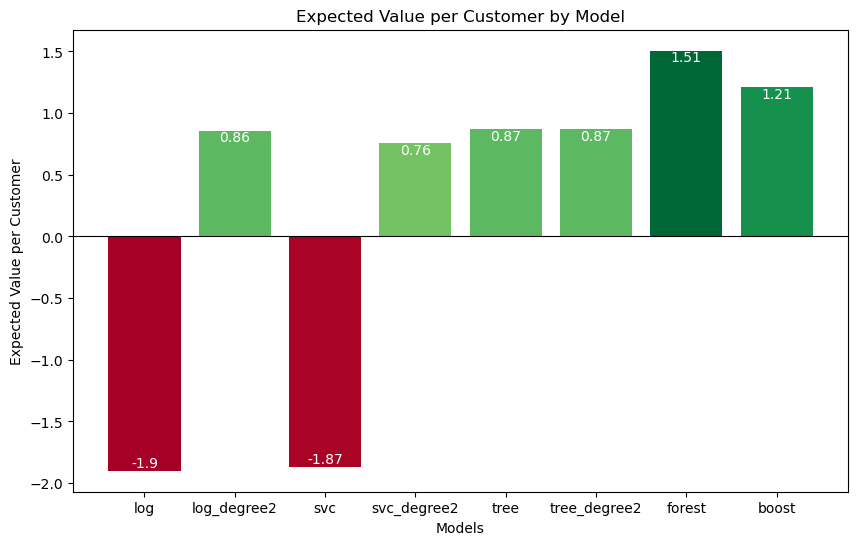

In [351]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming dict_values is already defined
models = list(dict_values.keys())
values = list(dict_values.values())

# Normalize the values to fit the range of the colormap
norm = plt.Normalize(min(values), max(values))
colors = cm.RdYlGn(norm(values))

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, values, color=colors)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Expected Value per Customer')
plt.title('Expected Value per Customer by Model')

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             round(yval, 2),
             ha='center', va='bottom' if yval < 0 else 'top',
             color='white')

# Draw a horizontal line at y=0
plt.axhline(0, color='black', linewidth=0.8)

# Show the bar chart
plt.show()


<div class="alert alert-block alert-success">
We conclude that the model that we expect to drive highest revenue is the random forest with GradienSearch, and considering all features in each tree of the forest (i.e., max_features = None).The second most profitable model is the Gradient Boosting model. Surprisingly, both individual tree models yield the same expected value. 
    
For linear svc and logistic classifier, it was crucial to consider polynomial features. Degree 1 models were not able to drive positive campaign revenues. 

</div>